## 2. EDA - Eksploracja danych

Opisz wnioski płynące z każdego wykresu, swoje hipotezy poprzyj testami statystycznymi takimi jak np. t-test lub Chi-square. Dodatkowo odpowiedz na poniższe pytania:
1.	W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?
2.	W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO
3.	W jaki sposób status kredytu hipotecznego na dom wiąże się z prawdopodobieństwem niewypłacalności?
4.	W jaki sposób roczny dochód wiąże się z prawdopodobieństwem niewykonania zobowiązania?
5.	W jaki sposób historia zatrudnienia wiąże się z prawdopodobieństwem niewykonania zobowiązania?
6.	Jak wielkość żądanej pożyczki jest powiązana z prawdopodobieństwem niewykonania zobowiązania?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from pandas.api.types import is_numeric_dtype, is_object_dtype # do robienia listy zmiennych numerycznych/kategorycznych

import time # przydaje się

In [2]:
#pliki python
import processing

In [3]:
df = pd.read_csv("Loan_data_after_processing.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39786 non-null  float64
 1   funded_amnt              39786 non-null  float64
 2   funded_amnt_inv          39786 non-null  float64
 3   term                     39786 non-null  int64  
 4   int_rate                 39786 non-null  int64  
 5   installment              39786 non-null  float64
 6   grade                    39786 non-null  object 
 7   sub_grade                39786 non-null  object 
 8   emp_length               39786 non-null  float64
 9   home_ownership           39786 non-null  object 
 10  annual_inc               39786 non-null  float64
 11  verification_status      39786 non-null  object 
 12  issue_d                  39786 non-null  object 
 13  loan_status              39786 non-null  object 
 14  purpose               

### Zmienna objaśniana

Naszą zmienną objaśnianą jest loan_status - informująca o tym, czy kredyt został spłacony (Fully Paid), czy nie (Charged Off).
Zmienna objaśniana ma wartości tekstowe, więc trzeba ją zrekodować na zmienna binarną. 

In [5]:
# rekodowanie zmiennej: Fully Paid - 1, Charged Off - 0
df['target'] = df['loan_status'].replace({"Fully Paid": 1, 'Charged Off': 0})

In [6]:
processing.print_distribution_in_percents(df, 'target')

0    14.25
1    85.75
Name: target, dtype: float64


Zmienna objaśniana niestety nie jest zbalansowana: zawiera dużo więcej wartości 1 - az 85%, niż wartości 0. To oznacza, że może być trudniej zbudować model, który będzie równie dobrze przewidywał wartości 0 i 1.
Trzeba będzie zadbać o to, aby w zbiorach treningowych i testowych były odpowiednie proporcje wartości zmiennej objaśnianej.

In [7]:
df = df.drop(columns = 'loan_status')

### Korelacje

<AxesSubplot:>

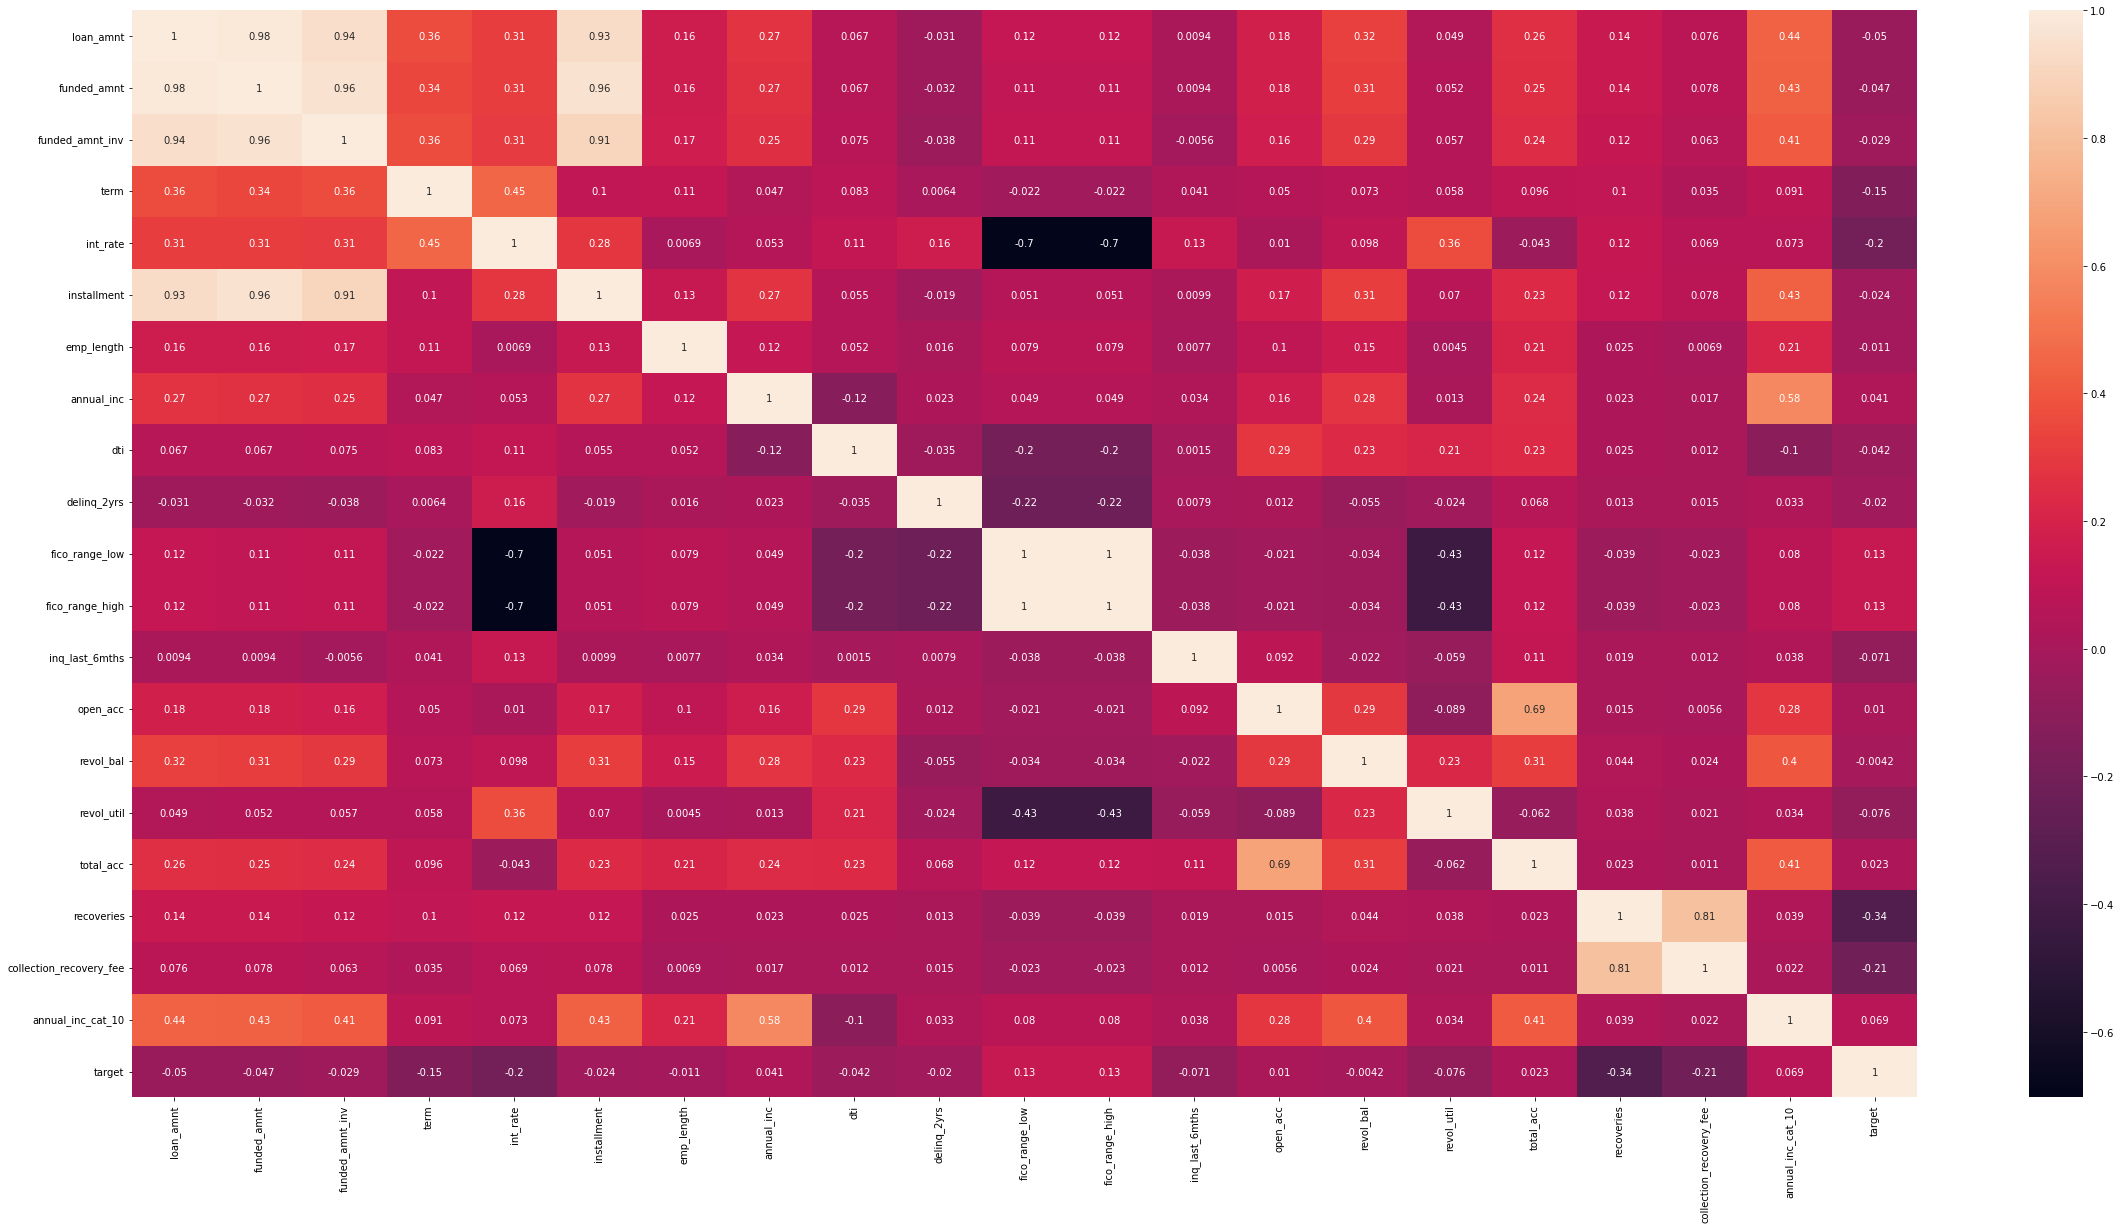

In [8]:
# korelacje
plt.figure(figsize = (40,20))       
sns.heatmap(df.corr(),annot = True)

Tablica korelacji pokazuje, że: 
- fico_range_low i fico_range_high sa liniowo skorelowane
- bardzo mocno skorelowane ze sobą są zmienne:
    - loan_amnt, funded_amnt, funded_emnt_inv, installment
    - recoveries, collecton_recovery_fee
    - fico_range_low, int_rate

Wyrzucam kolumnę fico_range_high, ponieważ jest maksymalnie skorelowana ze zmienną fico_range_low.

Wyrzucam również kolumny: funded_amnt oraz funded_amnt_inv, ponieważ są bardzo wysoko (>0,94) skorelowane z wysokością
wnioskowanego kredytu (co nie jest dziwne, bo według opisów również powinny być to bardzo zbliżone wartości)

In [9]:
df = df.drop(columns = ['fico_range_high', 'funded_amnt', 'funded_amnt_inv'])
df.shape

(39786, 26)

In [10]:
# lista korelacji z targetem posortowana malejąco
df.corr()['target'].abs().sort_values(ascending=False)

target                     1.000000
recoveries                 0.339993
collection_recovery_fee    0.209308
int_rate                   0.197918
term                       0.149151
fico_range_low             0.129262
revol_util                 0.075555
inq_last_6mths             0.071325
annual_inc_cat_10          0.069448
loan_amnt                  0.050035
dti                        0.041984
annual_inc                 0.041168
installment                0.023566
total_acc                  0.022640
delinq_2yrs                0.020197
emp_length                 0.011034
open_acc                   0.010199
revol_bal                  0.004166
Name: target, dtype: float64

In [11]:
# ogólny rzut oka na skale, wielkości (tutaj tylko zmienne numeryczne)
# na pewno są różne skale i będę je standaryzować
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,39786.0,11231.360277,7464.542832,500.00,5500.00,10000.00,15000.00,35000.00
term,39786.0,42.448499,10.638782,36.00,36.00,36.00,60.00,60.00
int_rate,39786.0,1202.787337,372.746646,542.00,925.00,1186.00,1459.00,2459.00
installment,39786.0,324.733637,208.923212,15.69,167.08,280.61,430.78,1305.19
emp_length,39786.0,4.959232,3.519685,0.00,2.00,4.00,9.00,10.00
annual_inc,39786.0,68979.066755,63762.634520,4000.00,40500.00,59000.00,82342.50,6000000.00
dti,39786.0,13.317794,6.678300,0.00,8.18,13.41,18.60,29.99
delinq_2yrs,39786.0,0.146534,0.491826,0.00,0.00,0.00,0.00,11.00
fico_range_low,39786.0,714.997989,35.840682,625.00,685.00,710.00,740.00,825.00
inq_last_6mths,39786.0,0.869049,1.070069,0.00,0.00,1.00,1.00,8.00


Powyżej skrócona analiza dla każdej zmiennej numerycznej. Poniżej będę omawiać uzyskane wyniki, a następnie zanalizuję zmienne kategoryczne.

LOAN_AMNT
count    39786.000000
mean     11231.360277
std       7464.542832
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64
Number of outliers in loan_amnt:  719
Średnia loan_amnt w podgrupach targetu:
target
0    12147.491182
1    11079.101448
Name: loan_amnt, dtype: float64



TERM
count    39786.000000
mean        42.448499
std         10.638782
min         36.000000
25%         36.000000
50%         36.000000
75%         60.000000
max         60.000000
Name: term, dtype: float64
Number of outliers in term:  0
Średnia term w podgrupach targetu:
target
0    46.340741
1    41.801618
Name: term, dtype: float64



INT_RATE
count    39786.000000
mean      1202.787337
std        372.746646
min        542.000000
25%        925.000000
50%       1186.000000
75%       1459.000000
max       2459.000000
Name: int_rate, dtype: float64
Number of outliers in int_rate:  38
Średnia int_rate w podgrupach tar

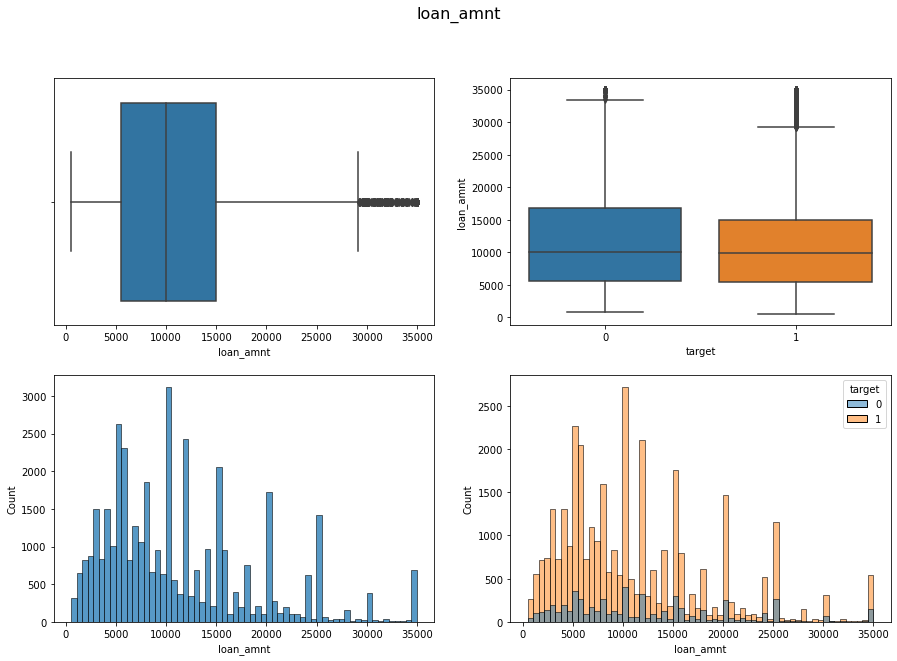

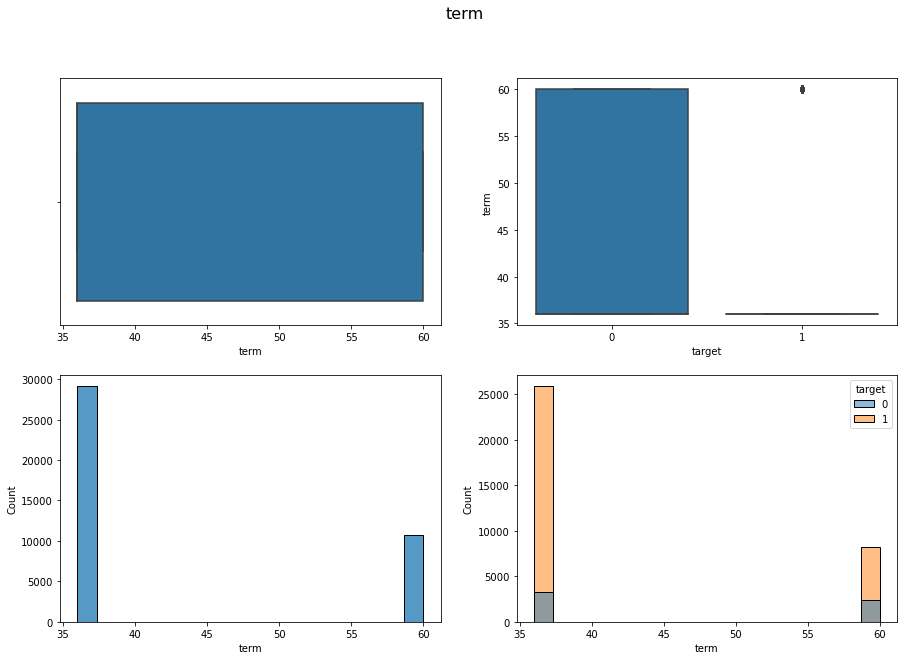

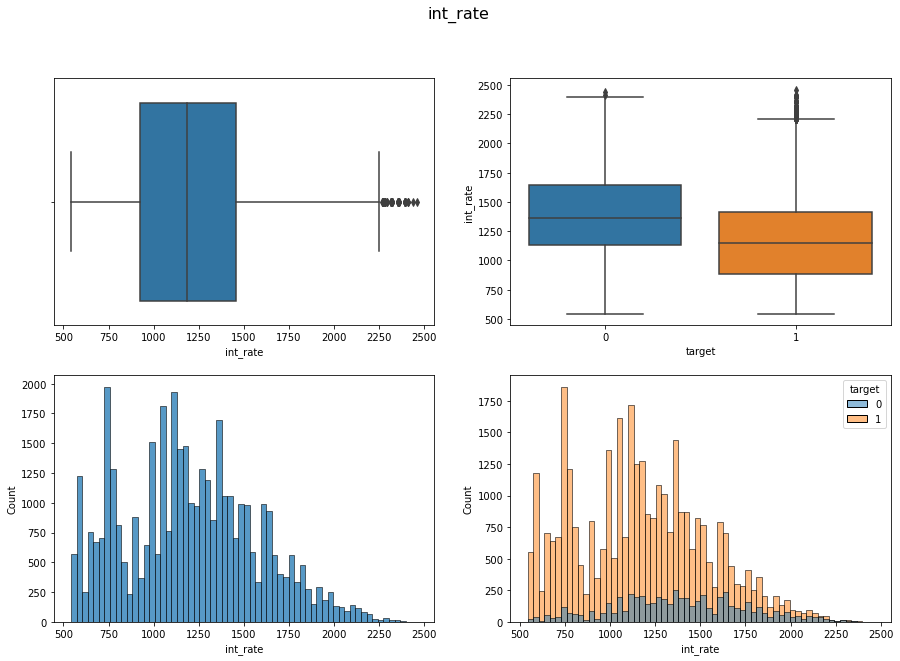

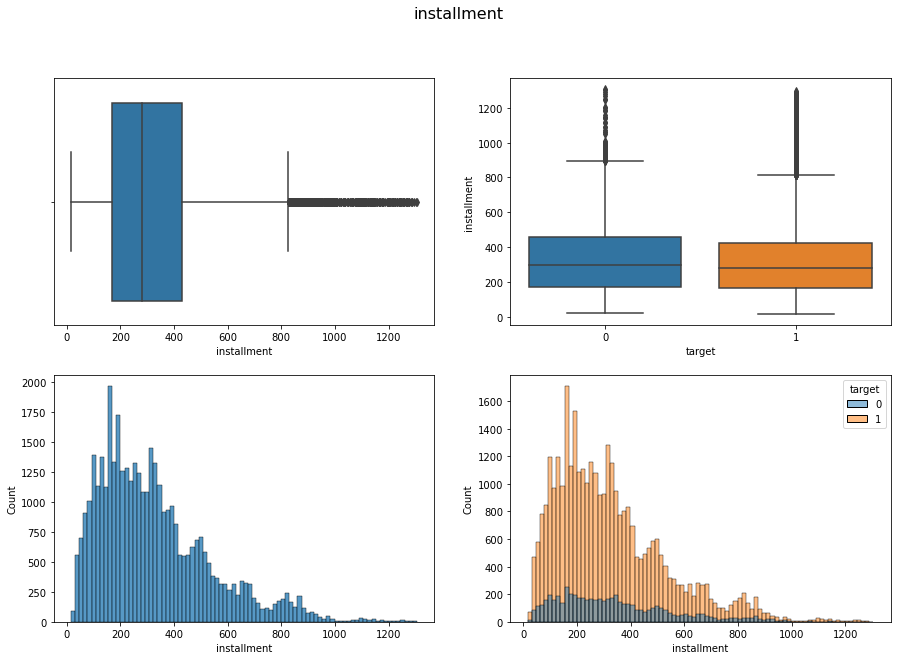

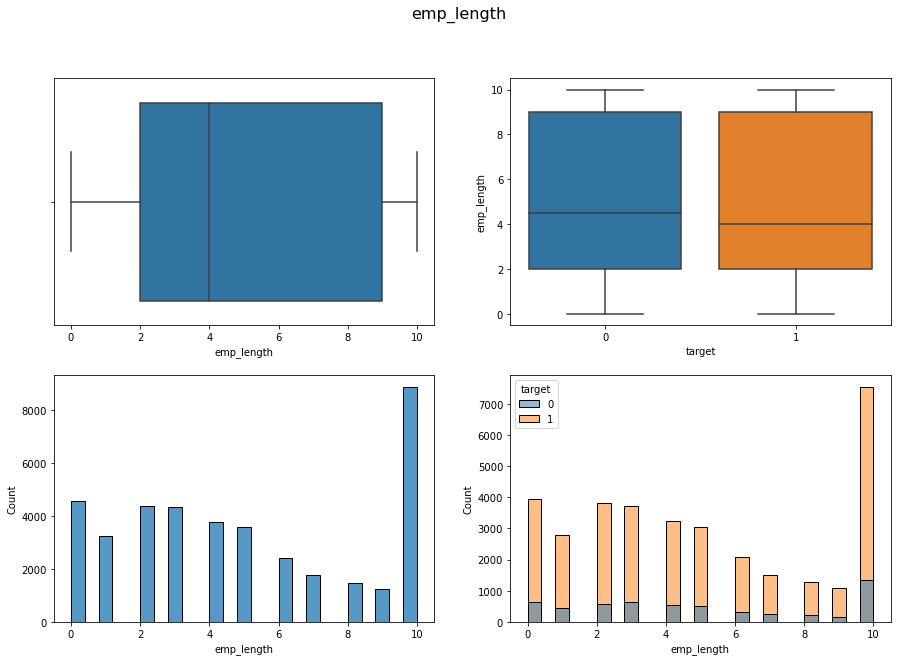

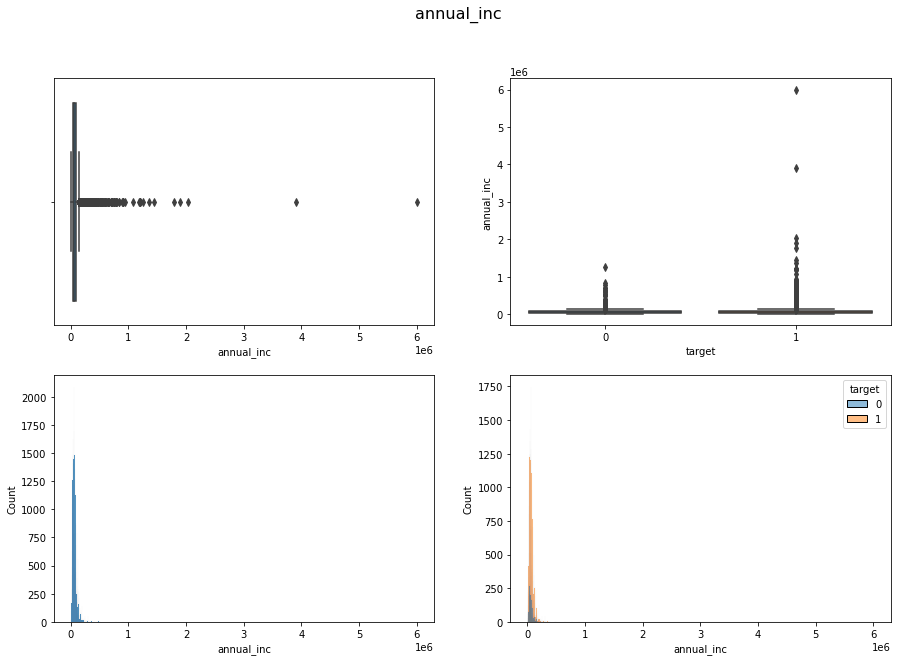

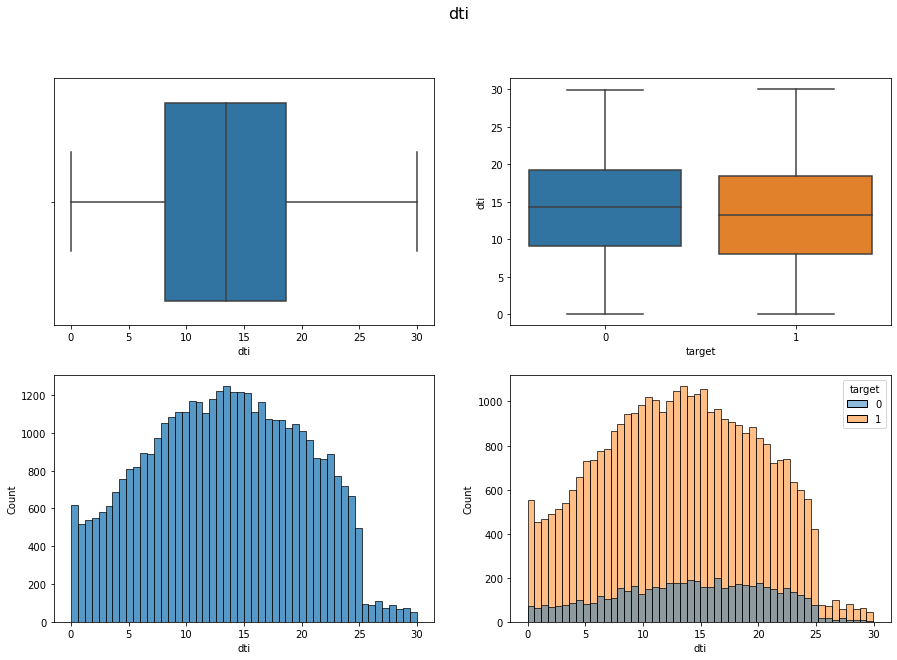

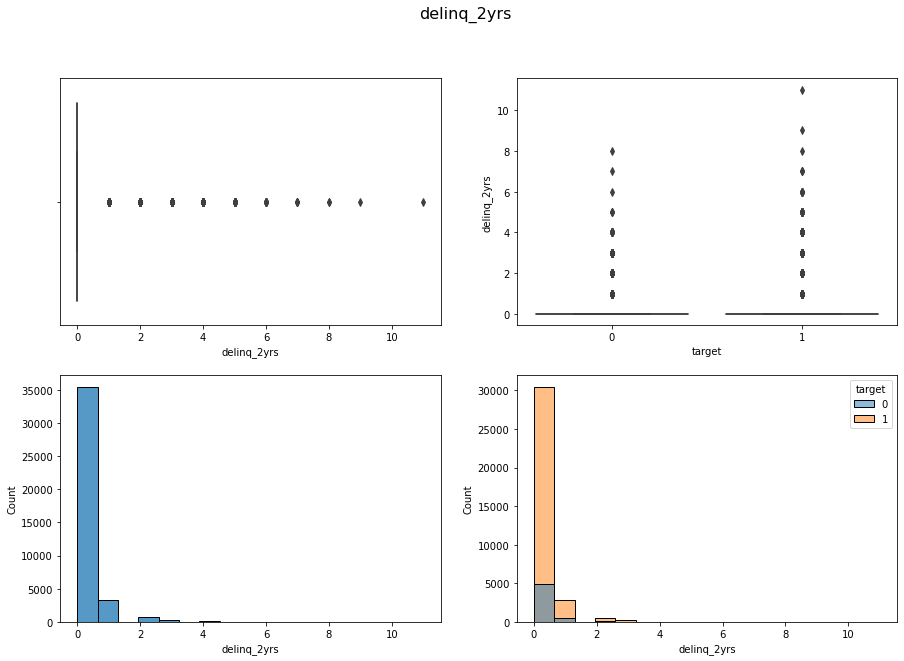

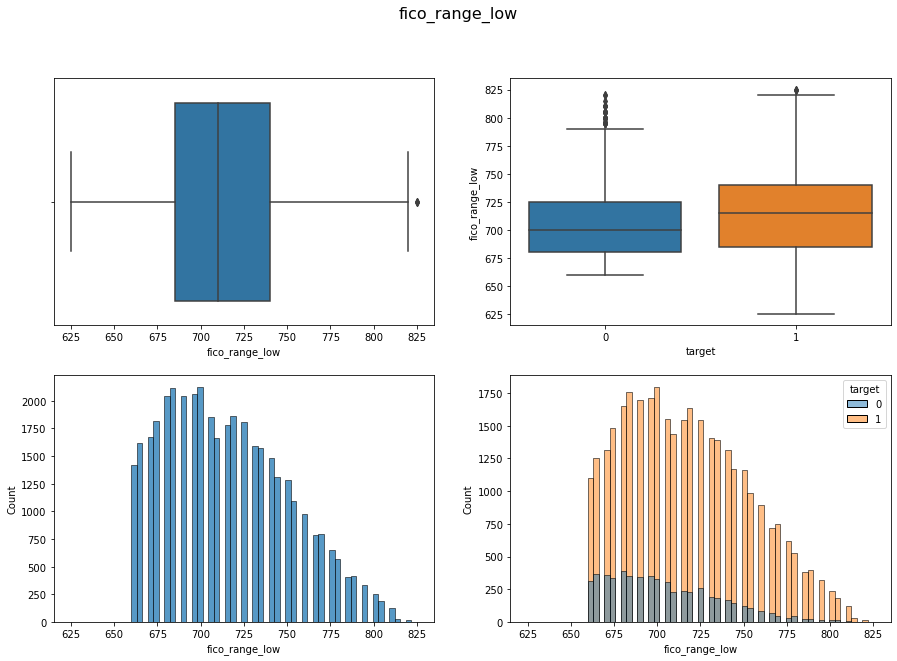

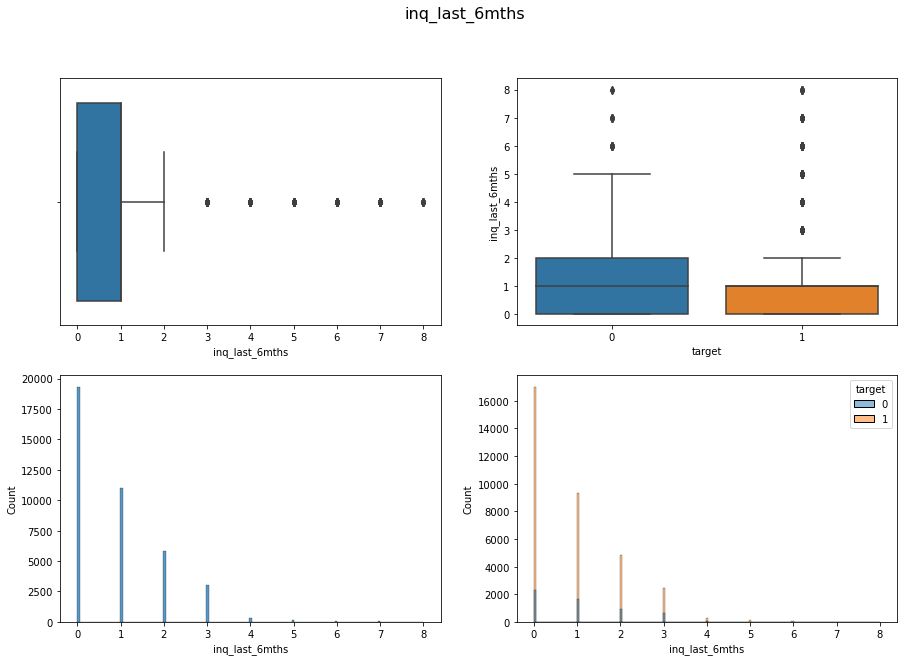

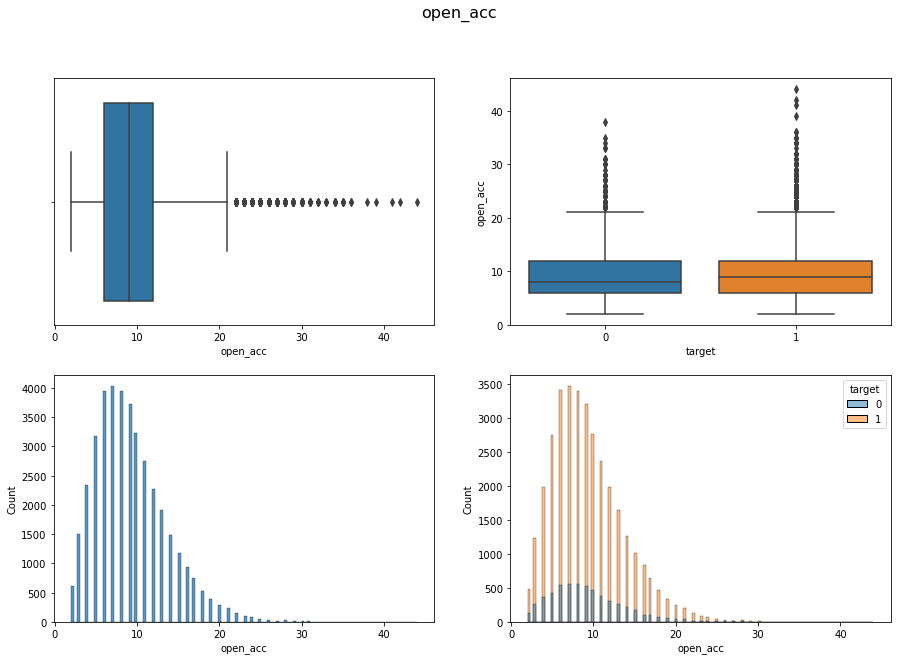

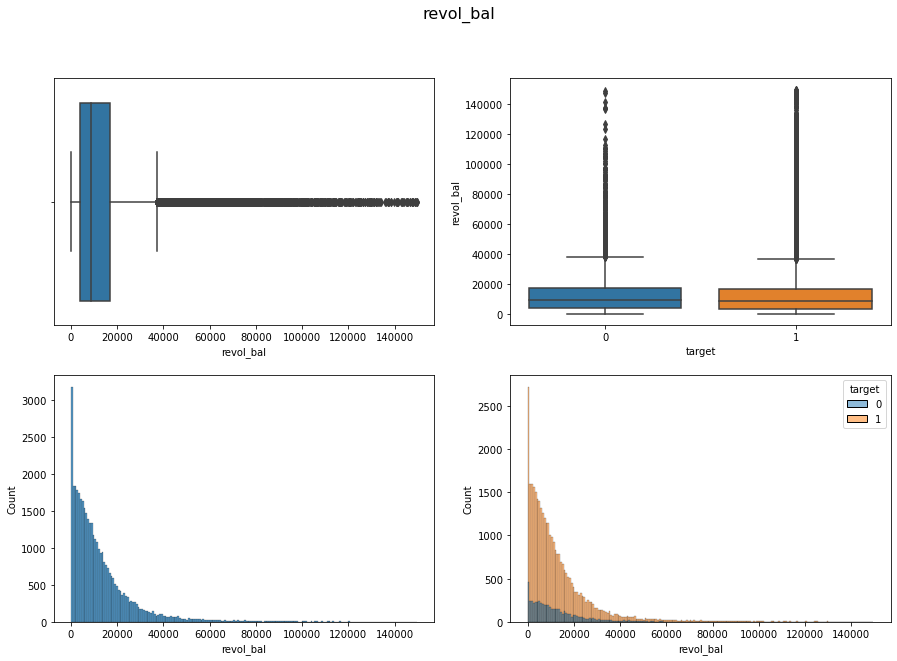

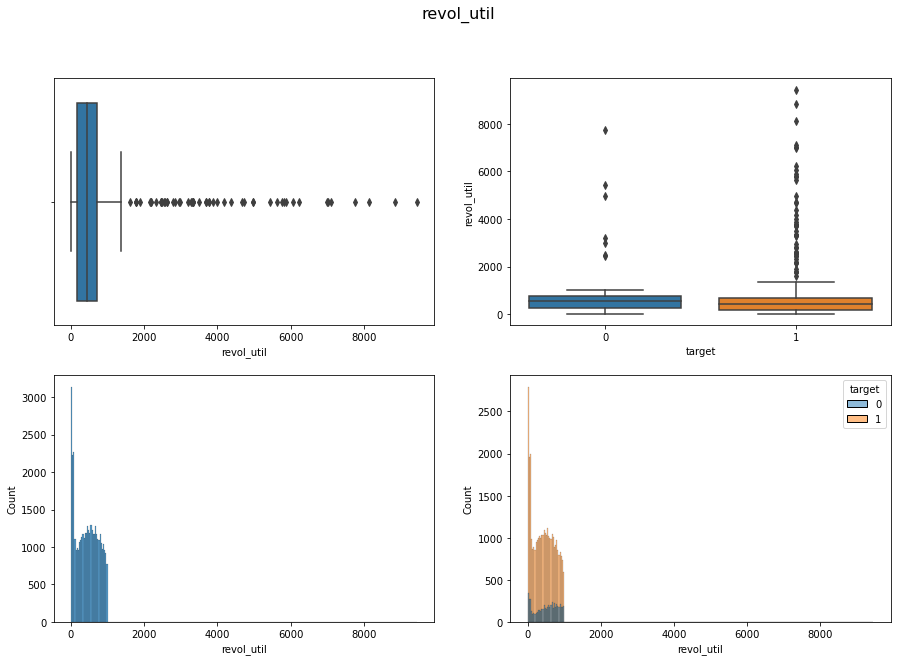

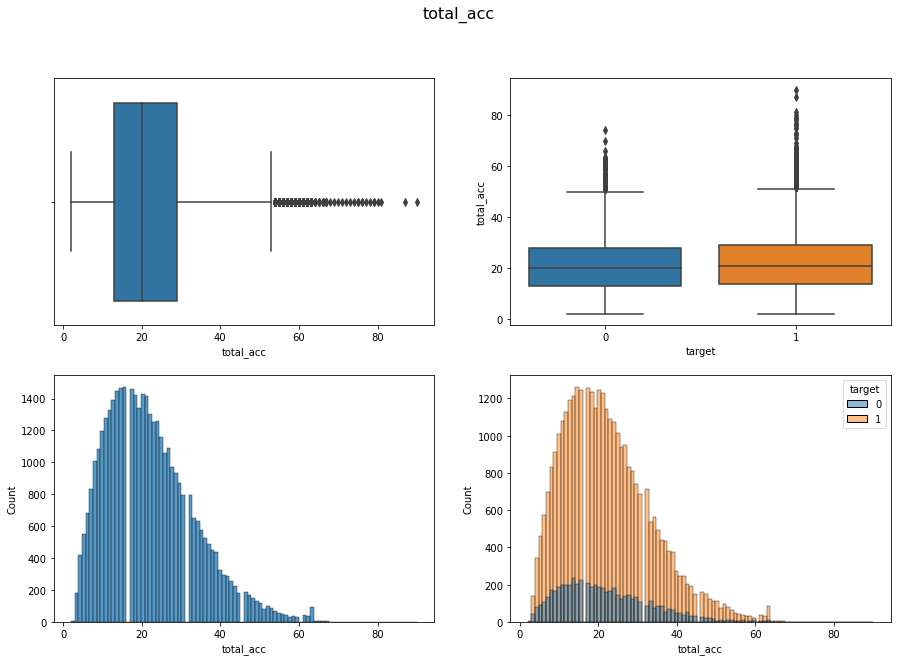

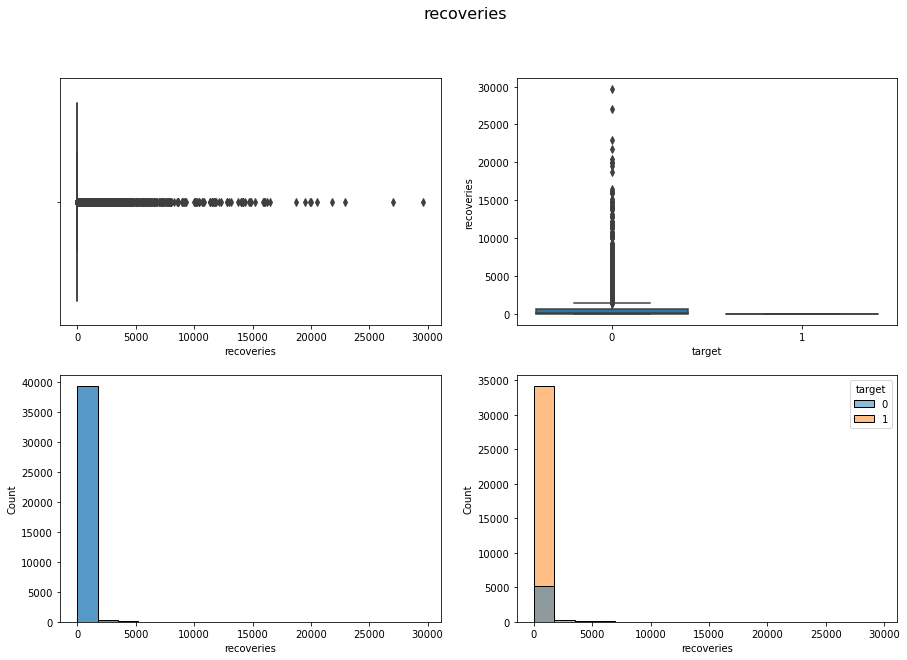

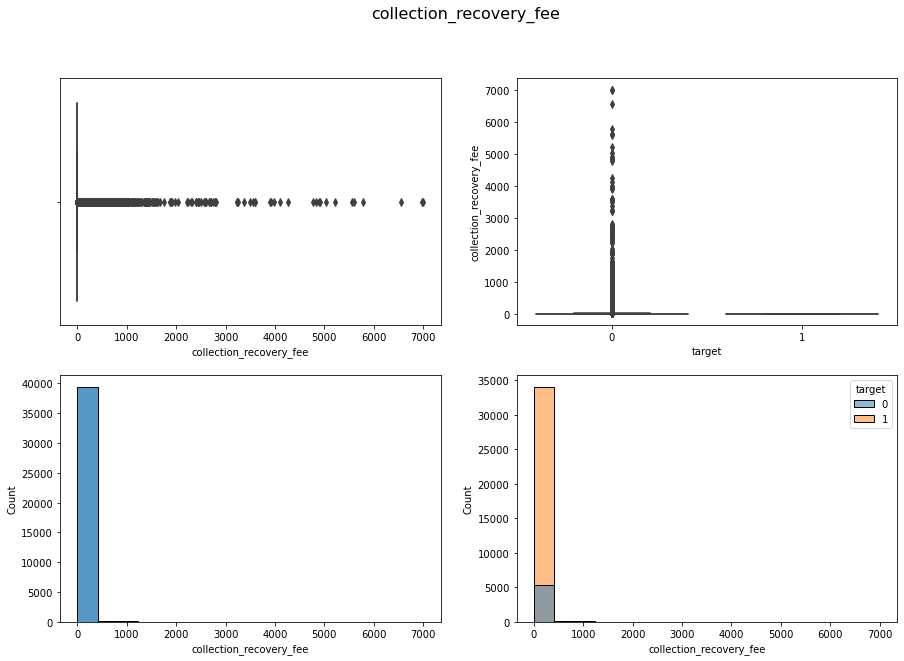

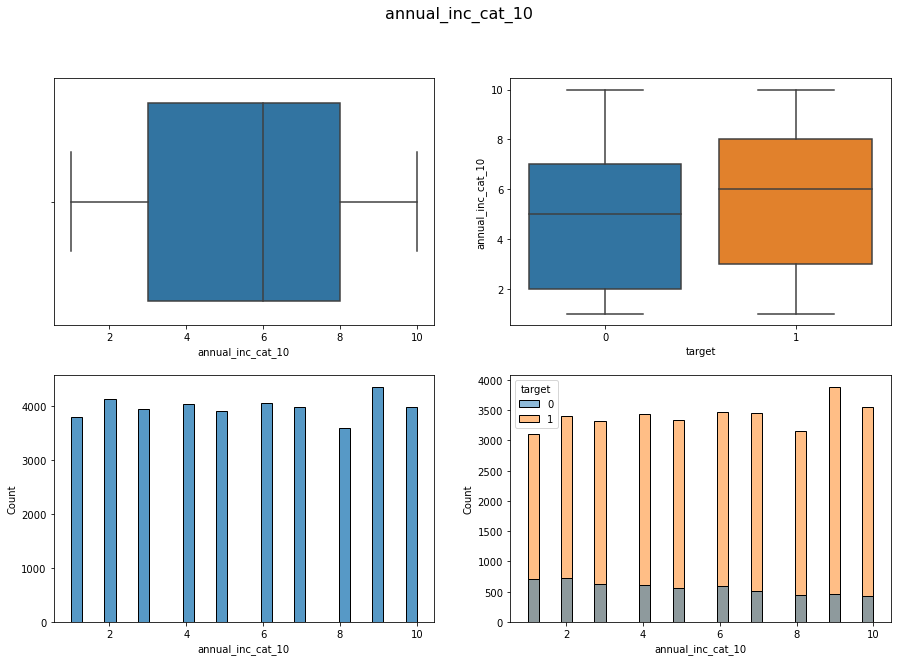

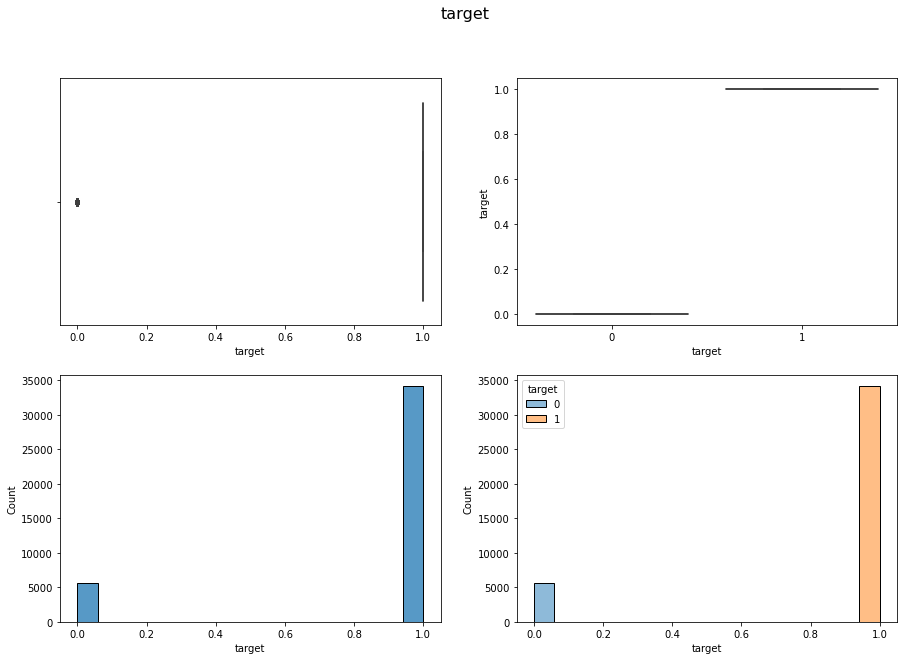

In [12]:
column_list = processing.create_numeric_column_list(df)
processing.display_analysis(df, column_list, 'target')
# todo: sprawdzić, czy działa

### loan_amnt

Wysokość kwoty kredytu:
- Wysokość kwoty kredytu w zbiorze waha się między 500 a 35000 (dolarów, natomiast dla 75% klientów jest to poniżej 15000.
- W zbiorze jest 719 obserwacji odstających.
- widać różnicę w rozkładach pomiędzy targetem 0 i 1, różnią się również średnie w tych podgrupach: 12147 dla 0 i 11079 dla 1.

### Jak wielkość żądanej pożyczki jest powiązana z prawdopodobieństwem niewykonania zobowiązania?

Na wykresach widać różnice w rozkładach pomiędzy obserwacjami ze spłaconym i niespłaconym kredytem. 
Wykonam więc t-test Studenta, aby sprawdzić, czy zaobserwowane różnice są istotne statystycznie. Formuuję hipotezę zerową o braku róznicy miedzy średnimi zmiennej loan_amnt dla kredytów spłaconych i niespłanowych. Hipotezą alternatywną jest hipoteza, że średnie te są od siebie różne.

In [13]:
# wykonuję t-test Studenta
processing.perform_ttest(df, 'target', 'loan_amnt')

T-test result: statistic = 9.992422364196793, p value =  1.753479937936575e-23


Otrzymaliśmy wartośc p value bliską 0.0, co oznacza graniczny poziom istotności, powyżej którego możemy odrzucić hipotezę zerową o braku różnic między średnimi. A zatem przyjmując standardowy poziom istotności 0,05 odrzucamy hipotezę zerową.

In [14]:
# przeprowadzę też test porównania median w grupach
processing.perform_mannwhitneyutest(df, 'target', 'loan_amnt')

Mann-Whitney U test result: result: statistic = 103109788.0, p value = 1.4054171733129413e-15


Test U Manna Whitneya potwierdza, że również mediany w podgrupach zmiennej target są różne. 

In [16]:
# Tworzę nową zmienną, aby wyodrębnić podgrupy według wysokości dochodu, aby w tych podgrupach policzyć średnie zmiennej target
processing.create_10_categories(df, 'loan_amnt', 'loan_amnt_cat_10')

<AxesSubplot:xlabel='loan_amnt_cat_10'>

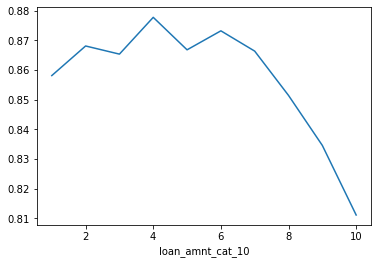

In [17]:
df.groupby('loan_amnt_cat_10')['target'].mean().plot()

In [18]:
df['loan_amnt'].quantile(q=0.6)

12000.0

Po podzieleniu zbioru na 10 podgrup według wysokości wnioskowanej kwoty kredytu i policzeniu średnich zmiennej trarget w tych podgrupach możemy zaobserwowac na wykresie tendencję, zgodnie z którą dla najwyższych wysokości kwoty kredytu odsetek osób spłacających wyraźnie spada. 
Co ciekawe, ta zależność jest widoczna tylko dla najwyższych kwot kredytu - powyżej 6 decyla, czyli 12 tysięcy USD, dla kwot niższych zależności nie widać.
Można więc sformułować hipotezę, że powyżej pewnego progu wysokości kwoty kredytu (w tym przypadku ok 12 tysięcy USD) prawdopodobieństwo spłacenia kredytu spada wraz ze wzrostem kwoty.

### term

In [19]:
df.groupby('term')['target'].mean()

term
36    0.889091
60    0.771469
Name: target, dtype: float64

Jest różnica w średnich - wśród tych, co mają krótszy termin spłacania kredytu większy odsetek go spłaca (89%)
niż wsród tych, którzy maja termin dłuższy (77%)

### int_rate

interest rate - oprocentowanie. 
- nie wiadomo w jakiej jednostce podana jest zmienna.
- obserwacje odstające: 38 – bardzo niewiele
- na wykresie boxplot widać, że rozkład interest rate wśród osób, które spłaciły kredyt różni się od rozkładu wśród pozostałych. Wśród tych pierwszych interest rate jest średnio mniejszy (1172) o ok 200 w stosunku do tych, co nie spłacili (1383). 

In [20]:
df.groupby('target')['int_rate'].mean()

target
0    1383.746914
1    1172.712276
Name: int_rate, dtype: float64

In [21]:
# wykonuję t-test Studenta
processing.perform_ttest(df, 'target', 'int_rate')

T-test result: statistic = 40.27328660272153, p value =  0.0


T test potwierdza na poziomie istotności 0.0, że średnie zmiennej int_rate w podgrupach zmiennej target różnią się.

### installment

Rata.
- Obserwacje odstające: 328
- Maksymalna rata to 1305, ale 75% klientów płaciło do 430 USD.
- Widoczna jest niewielka różnica między średnią ratą wśród 0 i 1 (odpowiednio 336 i 322) – wśród niespłacających odrobinę wyższa.

In [22]:
# wykonuję t-test Studenta
processing.perform_ttest(df, 'target', 'installment')

T-test result: statistic = 4.701807187162265, p value =  2.5873247625304582e-06


Różnica jest istotna statystycznie (p=0.0)

### emp_length

Długość zatrudnienia w latach.
- nie ma outlierów
- zmienna o wartościach 0-10, dyskretna
- Q1 = 2, med = 4, q3 = 9 - tutaj miałam robić jakąś dodatkową zmienną, ale chyba sobie odpuszczę
- na wykresie boxplot nie widać żadnej różnicy w rozkładzie między 0 i 1
- różnica średnich w podgrupach targetu jest malutka (0,1)

In [23]:
# wykonuję t-test Studenta
processing.perform_ttest(df, 'target', 'emp_length')

T-test result: statistic = 2.201051849801638, p value =  0.027738075760800122


T test potwierdza, że różnica jest istotna statystycznie na poziomie p=2,8%

### W jaki sposób historia zatrudnienia wiąże się z prawdopodobieństwem niewykonania zobowiązania?
Na to pytanie odpowiem przy pomocy zmiennej emp_length.

<AxesSubplot:xlabel='emp_length'>

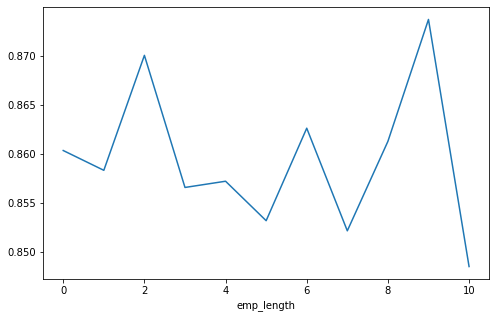

In [24]:
plt.figure(figsize=(8,5))
df.groupby('emp_length')['target'].mean().plot()

Na wykresie średniej targetu w podziale na lata zatrudnienia nie widać wyraźnej zależności między tymi zmiennymi. Różnice w średnich w poszczególnych kategoriach nie są duże. Wydaje się więc, że długość zatrudnienia nie wiąże się z różnicą w prawdopodobieństwie spłacenia kredytu.

### annual_inc

- 289 obserwacji odstających, które są tak mocno odstające, że nie pozwalają dojrzeć rozkładu na boxplotach
- jest różnica między średnim dochodem wśród niespłacających (62540 USD) i wśród spłacających (700049) – czyli spłacający zarabiają średnio o 7509 więcej niż niespłacający (o 12%)

In [25]:
# usuwam tymczasowo obserwacje odstające, po to żeby móc zobaczyć lepiej rozkład
df_temp = df.copy()
df_temp = df_temp[((df_temp['annual_inc'] - df_temp['annual_inc'].mean()) / 
    df_temp['annual_inc'].std()).abs() < 3]

ANNUAL_INC
count     39497.000000
mean      66040.618885
std       36445.568383
min        4000.000000
25%       40000.000000
50%       58500.000000
75%       81500.000000
max      260000.000000
Name: annual_inc, dtype: float64
Number of outliers in annual_inc:  694
Średnia annual_inc w podgrupach targetu:
target
0    60395.494537
1    66981.000529
Name: annual_inc, dtype: float64


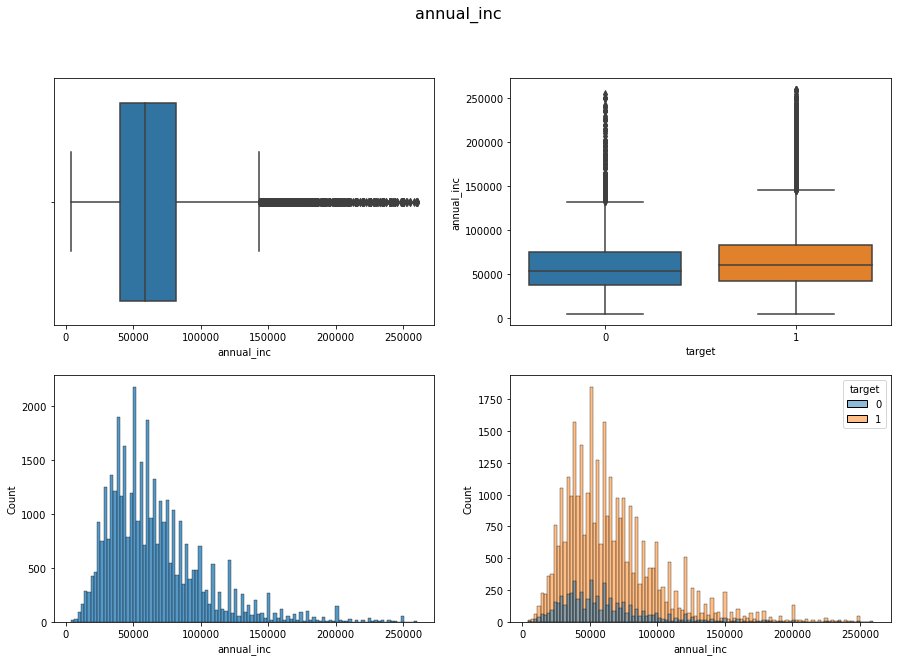

In [26]:
column_list = ['annual_inc']
processing.display_analysis(df, column_list, 'target')

Po usunięciu outlierów rozkład można już zobaczyć tę różnicę w średnich między dwiema podgrupami targetu. Grupa spłacająca jak widać ma nie tylko wyższą średnią dochodu, ale również wszystkie pozostałe statystyki opisowe (kwartyle, minimum i maksimum)

### W jaki sposób roczny dochód wiąże się z prawdopodobieństwem niewykonania zobowiązania?

Przy uwzględnieniu obserwacji odstających, różnica między średnim dochodem wśród niespłacających (62540 USD) a średnim dochodem wśród spłacających (700049) – wynosi 7509, czyli spłacający zarabiają średnio o 12% więcej niż niespłacający
Po usunięciu obserwacji odstających tendencja utrzymuje się, średnie zarobki wśród niespłacających kredytu wynoszą 60395 USD, a wśród spłacających 66981, czyli o ok 11% więcej.

Aby bardziej obrazowo wskazać różnice w prawdopodobieństwie spłacenia kredytu w zależności od deklarowanego dochodu rocznego, użyję stworzonej wcześniej zmiennej, dzielącej zbiór na podgrupy podw względem dochodu.

<AxesSubplot:xlabel='annual_inc_cat_10'>

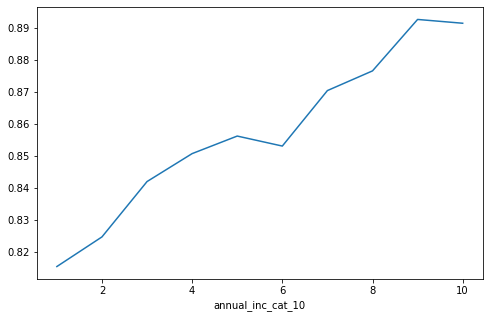

In [27]:
plt.figure(figsize=(8,5))
df.groupby('annual_inc_cat_10')['target'].mean().plot()

Na zaprezentowanym wykresie widać średnie zmiennej target w podgrupach wyznaczonych przez kolejne wartości dochodu rocznego. Średnie te można interpretować jako prawdopodobieństwo spłacenia kredytu.
Wyraźna jest tendencja wzrostowa, czyli im wyższy dochód, tym wyższe prawdopodobieństwo spłacenia kredytu - dla dochodu w najniższej kategorii prawdopodobieństwo spłacenia kredytu wynosi ok 81,5%, dla kolejnych kategorii jest coraz wyższe, a dla dwóch najwyższych kategorii dochodu wynosi już ponad 89%.

verification_status - to jest zmienna powiązana ze zmienną annual_inc - informuje o tym, czy dochód deklarowany został zweryfikowany, czy nie. 
Analiza zależności prawdopodobieństwa spłacenia zobowiązania i dochodu wzbogacona o informacje o zweryfikowaniu dochodu moze rzucić na nią nowe światło.

In [28]:
df['verification_status'].unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

Zmienną zrekoduję na dwie nowe zmienne - jedna będzie przechowywać informację o zweryfikowaniu dochodu, druga o zweryfikowaniu źródła dochodu (zakładam, że "verified" to w takiej sytuacji będzie zarówno zweryfikowany dochód, jak i źródło)

In [29]:
df['inc_ver_status'] = df['verification_status'].replace({
    "Verified": 1, 
    'Source Verified': 0, 
    "Not Verified": 0,
})

df['inc_source_ver_status'] = df['verification_status'].replace({
    "Verified": 1, 
    'Source Verified': 1, 
    "Not Verified": 0,
})

In [30]:
df_temp['inc_ver_status'] = df_temp['verification_status'].replace({
    "Verified": 1, 
    'Source Verified': 0, 
    "Not Verified": 0,
})

df_temp['inc_source_ver_status'] = df_temp['verification_status'].replace({
    "Verified": 1, 
    'Source Verified': 1, 
    "Not Verified": 0,
})

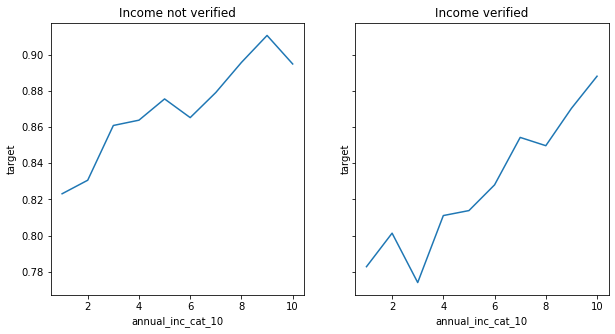

In [31]:
# wyświetlam zależność między podgrupami dochodu a średnią targetu dla dwóch zbiorów: osób o zweryfikowanym 
# dochodzie oraz o niezweryfikowanym dochodzie.

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.plot(df.loc[df['inc_ver_status'] == 0].groupby('annual_inc_cat_10')['target'].mean())
ax1.set_title('Income not verified')
ax1.set(xlabel='annual_inc_cat_10',ylabel='target')
ax2.plot(df.loc[df['inc_ver_status'] == 1].groupby('annual_inc_cat_10')['target'].mean())
ax2.set_title('Income verified')
ax2.set(xlabel='annual_inc_cat_10',ylabel='target')
plt.show()

<!-- Wśród tych, którzy mieli dochód zweryfikowany, odsetek osób, które spłaciły kredyt jest mniejszy (84%) niż wśród tych z dochodem niezweryfikowanym (87%). -->

Można zauważyć, że wśród tych osób, których dochody zostały zweryfikowane krzywa zalezności średniej targetu od dochodu przebiega niżej, to znaczy dla tego samego dochodu prawdopodobieństwo spłacenia kredytu dla osoby z niezweryfikowanym dochodem jest wyższe, niż dla osoby z dochodem zweddyfikowanym. 
Jest to zależność zaskakująca, pewnie warto byłoby jeszcze potwierdzić jej istotność testami.

In [32]:
df.groupby('inc_ver_status')['target'].mean()

inc_ver_status
0    0.866528
1    0.838524
Name: target, dtype: float64

Średnia zmiennej target rzeczywiście jest nieco wyższa dla osób o niezweryfikowanym dochodzie. Przeprowadzę test, aby sprawdzić, czy różnica ta jest istotna statystycznie.

In [33]:
processing.perform_ttest(df, 'inc_ver_status', 'target')

T-test result: statistic = 7.476147581072598, p value =  7.810321538942734e-14


Różnica ta jest istotna statystycznie (p=0.0).

<!-- Wśród tych, którzy spłacili kredyt, odsetek osób, które miały zweryfikowany dochód jest mniejszy (32%) niż wśród tych, którzy nie spłacili (37%). -->

### dti

- wskaźnik stosunku długów do zarobków (skala od 0 do 30)
- wśród spłacających średni wskażnik jest o 1 niższy (13) niż wśród niespłacających (14)

### delinq_2yrs

- opóźnienia w spłatach w ostatnich 2 latach 
- wyraźna większość ma wartośc 0 (ponad 75%), kilka procent 1, i niewielki odsetek osób, które maja więcej opóźnień (max 11)
- jest też sporo outliersów – to ta niewielka grupa z większą liczbą opóźnień na koncie. (1011)
- w grupie osób niespłacających średnia liczba opóźnień w spłatach jest o ułamek wyższa (0,17) od średniej wśród osób spłacających (0,14)


### fico_range_low

- punktacja między min 625 pkt (czyli wcale nie dół skali), max 825 pkt
- 3 obserwacje odstające
- wśród spłacających średnia 716 pkt, wśród niespłacających 703
- wśród spłacających większy zakres i zróżnicowanie (odchylenie standardowe)

### W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?

Na boxplotach widać, że średnie w podgrupach zmiennej target różnią się - średnia wśród osób niespłacających jest niższa, niż wśród osób spłacających.
Dodatkowo na histogramach można zauważyć różnicę w kształcie wykresu -  wykres dla grupy spłacających ma trochę inny kształt niż wykres niespłacających - dla tych pierwszych modalna oraz zbiór najczęstszych wartości znajduje się bliżej środka skali, podczas gdy dla pozostałych najczęstszymi wartościami są te z początku skali - najniższe.

In [34]:
df.groupby('fico_range_low_cat')['target'].mean().sort_index()

fico_range_low_cat
2. Fair           0.775255
3. Good           0.843319
4. Very Good      0.913271
5. Exceptional    0.946254
Name: target, dtype: float64

Powyższy rozkład przedstawia średnie zmiennej target w podgrupach zmiennej wskazującej, w której kategorii/randze FICO mieści się klient (załącznik). "Fair" oznacza drugą w kolejności najniższą rangę, czyli klient niosący ryzyko niespłacenia, następnie jest "Good" - trzecia, "Very Good" - czwarta i najlepsza - "Exceptional" - czyli klient wyjątkowo godny zaufania.

Na powyższym rozkładzie możemy zobaczyć wyraźnie różnice między średnimi zmiennej target w różnych kategoriach
zmiennej oznaczającej kategorię FICO. W grupie "Fair" średnia zmiennej target jest
najniższa (77%), co oznacza największy odsetek osób, które nie spłaciły kredytu (23%). W kolejnych grupach średnia ta rośnia aż osiąga najwyższą wartość (94%) w grupie "Exceptional" - czyli w tej grupie odsetek osób, które nie spłaciły zadłużenia wynosi juz tylko 6%.

To oznacza, że mogę sformułować hipotezę, że im wyższa punktacja FICO, tym wyższe prawdopodobieństwem spłacenia kredytu.
Formuuję hipotezę zerową, że średnia FICO score w grupie osób, które spłaciły kredyt, oraz w grupie, która nie spłaciła
kredytu, jest taka sama.
Hipoteza alternatywna jest taka, że te średnie nie są równe.
<!-- (a co jeśli bym chciała sformułować hipotezę, że średnia fico
score wśród osób, które spłaciły, jest wyższa niż wśród pozostałych? w jaki sposób wtedy zmodyfikować ten test?) -->
Weryfikuję hipotezę zerową na poziomie istotności alpha = 0,05.

In [35]:
processing.perform_ttest(df, 'target', 'fico_range_low')

T-test result: statistic = -26.0006449840463, p value =  8.403287195589305e-148


Wynik t-testu potwierdza (p=0.0), że różnica średnich zmiennej fico_range_low w podgrupach zmiennej target jest istotna statystycznie.

Innym sposobem wskazania zależności jest porównanie średnich w odwrotnym kierunku.

In [36]:
# W tym celu zrekoduję zmienną kategoryczną fico_range_low_cat na numeryczną
df['fico_range_low_cat_num'] = df['fico_range_low_cat'].replace({
    "1. Poor": 1, 
    '2. Fair': 2, 
    "3. Good": 3, 
    "4. Very Good": 4, 
    "5. Exceptional": 5
})
df['fico_range_low_cat_num'] = pd.to_numeric(df['fico_range_low_cat_num'])

In [37]:
print('Charged Off')
processing.print_distribution_in_percents(df.loc[df['target']==0], 'fico_range_low_cat_num')
print('\n\nFully Paid')
processing.print_distribution_in_percents(df.loc[df['target']==1], 'fico_range_low_cat_num')

Charged Off
2    12.05
3    71.90
4    15.47
5     0.58
Name: fico_range_low_cat_num, dtype: float64


Fully Paid
2     6.91
3    64.32
4    27.07
5     1.70
Name: fico_range_low_cat_num, dtype: float64


Wśród niespłacających jest większy odsetek obserwacji w dwóch grupach o niższych rangach (Fair i Good) w stosunku do spłacających, natomiast wśród tych ostatnich większy jest odsetek obserwacji w dwóch grupach o rangach wyższych (Very Good i Exceptional) co potwierdza wnioski z poprzedniej analizy.

In [38]:
# sprawdzam też test niezależności rozkładów chi square
values_distribution_0 = df.loc[df['target']==0]['fico_range_low_cat_num'].value_counts().sort_index()
values_distribution_1 = df.loc[df['target']==1]['fico_range_low_cat_num'].value_counts().sort_index()
stats.chisquare(100*(values_distribution_0/len(df.loc[df['target']==0].index)), 
                100*(values_distribution_1/len(df.loc[df['target']==1].index)))
# jeśli pandas series jest arraylike (TODO: zapytać, czy tak można)

Power_divergenceResult(statistic=10.430240100514068, pvalue=0.015241663071346208)

### inq_last_6mths

- 260 outliers
- większość klientów miała 0 lub 1 zapytanie
- jest różnica w średniej liczbie zapytań między tymi, którzy spłacili kredyt i tymi, którzy go nie spłacili - ci pierwsi mieli średnio mniej zapytań

<AxesSubplot:xlabel='inq_last_6mths'>

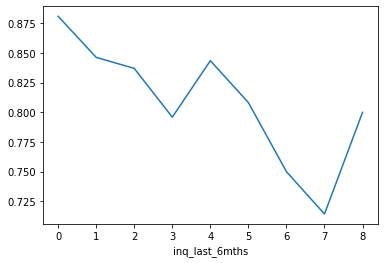

In [39]:
df.groupby('inq_last_6mths')['target'].mean().plot()

Po zwizualizowaniu średnich zmiennej target w zależności od liczby zapytań, możemy zauważyć niemonotoniczną, bardzo ogólną tendencję, zgodnie z którą wśród klientów z większą liczbą zapytań był średnio mniejszy odsetek osób spłacających kredyt. Wśród tych z zerem zapytań odsetek spłacających jest najwyższy (powyżej 87%) natomiast najniższy jest dla klientów z liczbą zapytań równą 7 (poniżej 72,5%). Jednak już przy 8 zapytaniach odsetek ten wzrasta - tendencja nie jest więc jednoznaczna.

### open_acc

- outliers: 373
- zakres od 2 do 44
- średnie podobne (9,1 dla 0, 9,3 dla 1)

### total_acc

- outliers: 354
- zakres 2-90
- średnie również podobne, 21,5 dla 0, 22,2 dla 1 – nieco więcej dla spłacających, różnica niewielka, ale mediana też jest trochę wyższa dla spłacających
- czyli można sformułować hipotezę, że ci, co maja większe doświadczenie z produktami kredytowymi (maja więcej kiedykolwiek otwartych produktów kredytowych) mają większe prawdopodobieństwo spłacenia kredytu w LC

###  revol_bal

 - 872 outliers
- zmienna o wysokim zakresie
- modalną jest 0, z histogrmau wynika, że im wyższa wartośc, tym mniejsza częstość
- niewielka różnica w średnich w grupach 0 i 1 (odpowienio 13554 i 13364)- czyli spłacający maja niższą średnią

### revol_util

- 54 outliers – ale za to tutaj te outliers są bardzo odstające, jak widac na histogramie, więc spróbujmy je usunąć
- różnica w średnich w grupach 0 i 1 (odpowienio 512 i 439) – spłacający mają niższą średnią

In [40]:
# tymczasowo usuwam outliers, żeby przyjrzeć się rozkładowi zmiennej
df_temp = df.copy()
df_temp = df_temp[((df_temp['revol_util'] - df_temp['revol_util'].mean()) / 
    df_temp['revol_util'].std()).abs() < 3]

REVOL_UTIL
count    39732.000000
mean       445.219823
std        299.592751
min          0.000000
25%        165.000000
50%        444.000000
75%        698.000000
max       1356.000000
Name: revol_util, dtype: float64
Number of outliers in revol_util:  1
Średnia revol_util w podgrupach targetu:
target
0    507.751722
1    434.825677
Name: revol_util, dtype: float64


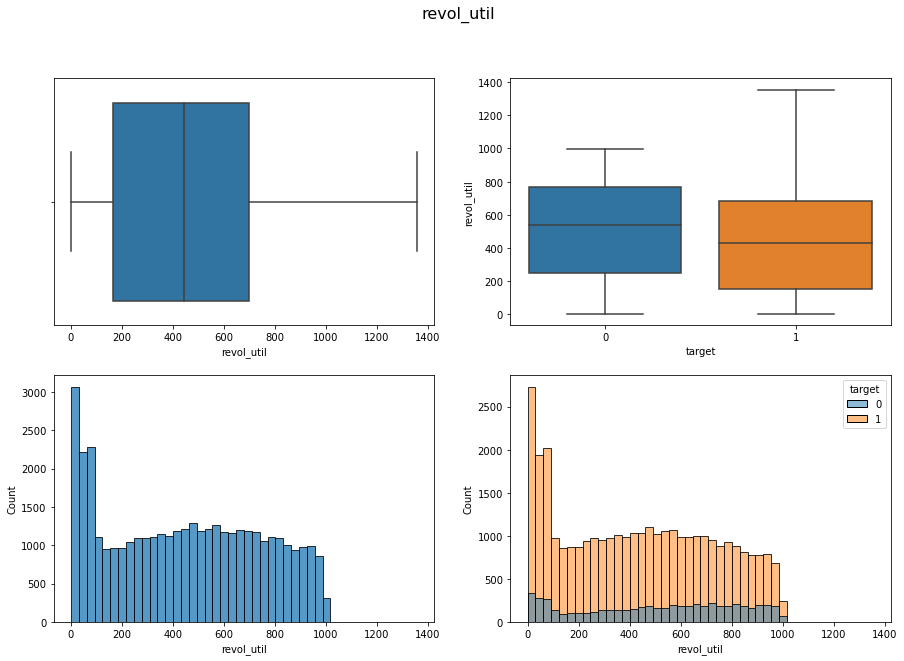

In [41]:
column_list = ['revol_util']
processing.display_analysis(df, column_list, 'target')

Po usunięciu outlierów lepiej widać rozkład zmiennej, widac tez wyraźniej różnice w podgrupach targetu - że wśród spłacających niższe są: średnia, mediana, 1 i 3 kwartyl, a także większy zakres.

### recoveries

- 378 outliers
- tutaj również większośc to 0 (3 kwartyl to 0), natomiast niezerowe wartości osiągają aż 29,6 tys
- wśród spłacających wszyscy mają wartość 0, wartości niezerowe pojawiają się tylko wśród niespłacających – to każe przypuszczać, że jest to zmienna z przyszłości, niosąca informacje o przebiegu procesu spłacania danego kredytu
- dodatkową przesłanką do takiego przypuszczenia jest stosunkowo wysoka korelacja liniowa między tą zmienną a targetem - 0,34.
- wniosek – trzeba usunąć tę zmienną


In [42]:
df = df.drop(columns='recoveries')

 ### collection_recovery_fee

- outliers 286
- identyczna sytuacja jak powyżej – średnia wśród spłacających – zero, czyli wszyscy spłacający mają tutaj wartość zero, niezerowe wartości tylko wśród niespłacających
- korelacja liniowa między tą zmienną a targetem - 0,21
- zmienna ta jest logicznie powiązana z powyższą (oraz wysoko skorelowana)
- wniosek – trzeba wyrzucić tę zmienną

In [43]:
df = df.drop(columns='collection_recovery_fee')

In [44]:
df.to_csv('Loan_data_after_eda_part.csv', index=False)

## Pozostałe zmienne - daty

### earliest_cr_line

In [45]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], dayfirst=True)

Wydobywam z niej informacje o roku i miesiącu.

In [46]:
df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year
df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month

EARLIEST_CR_LINE_YEAR
count    39786.000000
mean      1996.559267
std          6.826294
min       1946.000000
25%       1993.000000
50%       1998.000000
75%       2001.000000
max       2008.000000
Name: earliest_cr_line_year, dtype: float64
Number of outliers in earliest_cr_line_year:  585
Średnia earliest_cr_line_year w podgrupach targetu:
target
0    1996.934392
1    1996.496922
Name: earliest_cr_line_year, dtype: float64
EARLIEST_CR_LINE_MONTH
count    39786.000000
mean         6.891268
std          3.540731
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: earliest_cr_line_month, dtype: float64
Number of outliers in earliest_cr_line_month:  0
Średnia earliest_cr_line_month w podgrupach targetu:
target
0    6.735626
1    6.917136
Name: earliest_cr_line_month, dtype: float64


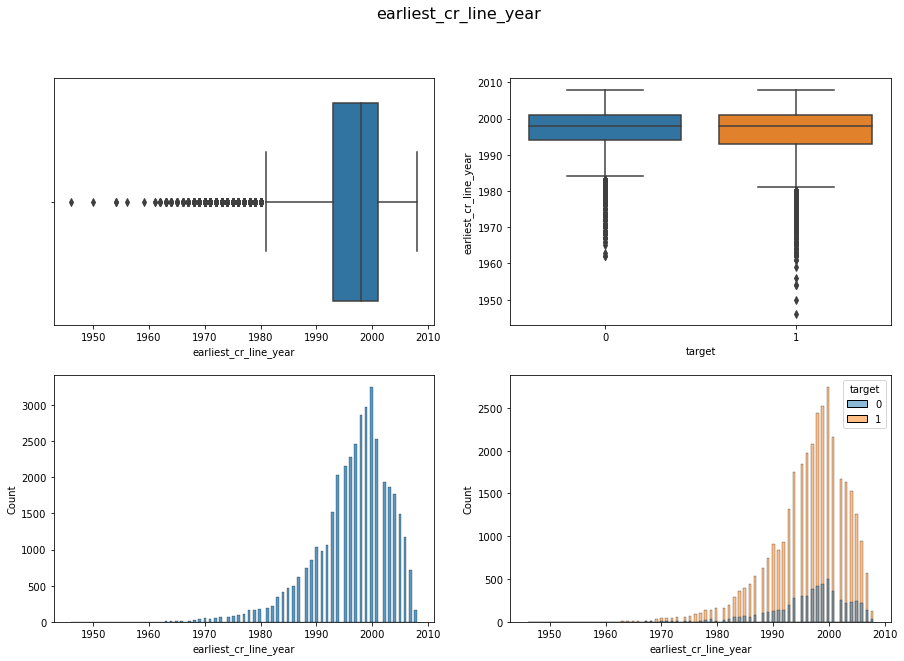

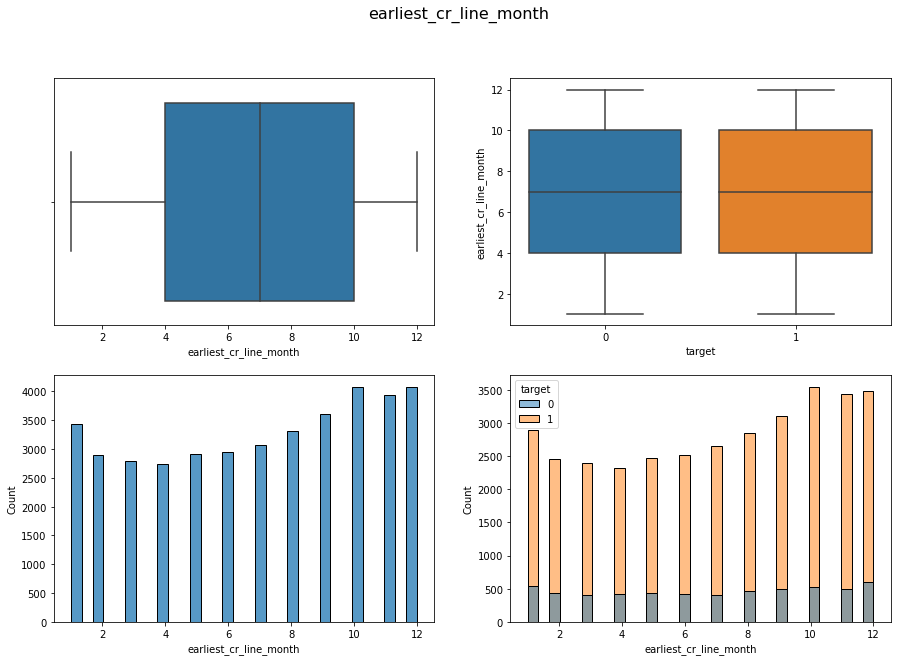

In [47]:
column_list = ['earliest_cr_line_year', 'earliest_cr_line_month']
processing.display_analysis(df, column_list, 'target')

 ### earliest_cr_line_year

- klienci mają najwcześniejsze doświadczenia z produktem kredytowym między rokiem 1946 a 2008
- różnica w średnich jest niewielka – w obu podgrupach targetu jest to rok 1996, z kolei mediana w obu grupach równa jest 1998.
- 585 outliers

In [48]:
df.groupby('target')['earliest_cr_line_year'].describe().T

target,0,1
count,5670.000000,34116.000000
mean,1996.934392,1996.496922
std,6.751826,6.836695
min,1962.000000,1946.000000
25%,1994.000000,1993.000000
50%,1998.000000,1998.000000
75%,2001.000000,2001.000000
max,2008.000000,2008.000000


Co ciekawe, najwyższy „wiek kredytowy”, czyli najwcześniejsze wartości roku w tej zmiennej pojawiają się w grupie osób spłacających. Wśród nich najwczesniejsza data otwarcia produktu kredytowego to 1946, natomiast wśród niespłacających - 1962

### earliest_cr_line_month

- tutaj rozkład dość równomierny, zauważalna przewaga miesięcy jesienno-zimowych w otwieraniu pierwszych linii kredytowych – ale to już analiza niedotycząca naszego tematu.

In [49]:
df.groupby('earliest_cr_line_month')['target'].mean()

earliest_cr_line_month
1     0.842504
2     0.850017
3     0.855508
4     0.845650
5     0.852374
6     0.855733
7     0.866319
8     0.858135
9     0.861628
10    0.869427
11    0.872238
12    0.852624
Name: target, dtype: float64

Różnice w średnich w poszczególnych miesiącach są niewielkie - miedzy 0,842 w styczniu, a 0,87 w listopadzie.

### W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO
Wiek kredytowy rozumiem jako czas, który upłynął od pierwszej styczności klienta z produktem o charakterze kredytowym - możemy więc do jego określenia użyć zmiennej earliest_cr_line_year

Aby przedstawić obrazowo związek wieku kredytowego, prawdopodobieństwa niewykonanaia zobowiązania oraz wyniku FICO, użyję zmiennej kategoryzowanej fico_range_low_cat_num.

<AxesSubplot:xlabel='fico_range_low_cat_num', ylabel='earliest_cr_line_year'>

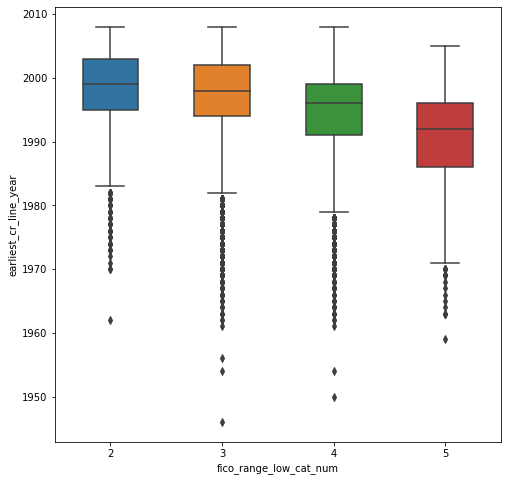

In [50]:
plt.figure(figsize=(8,8))
sns.boxplot(x="fico_range_low_cat_num", y="earliest_cr_line_year", data=df, width=0.5)

Na wykresie widać, że rozkłady earliest_cr_line_year różnią się w podgrupach zmiennej fico_range_low_cat_num: im wyższa
grupa FICO (bardziej godna zaufania), tym wcześniejsze lata stanowią większość w zbiorze. Może to wynikać z tego, że wiek
kredytowy może być czynnikiem wpływającym na wartość FICO score i tym samym wartości te są od siebie częściowo zależne.

<AxesSubplot:xlabel='fico_range_low_cat_num', ylabel='earliest_cr_line_year'>

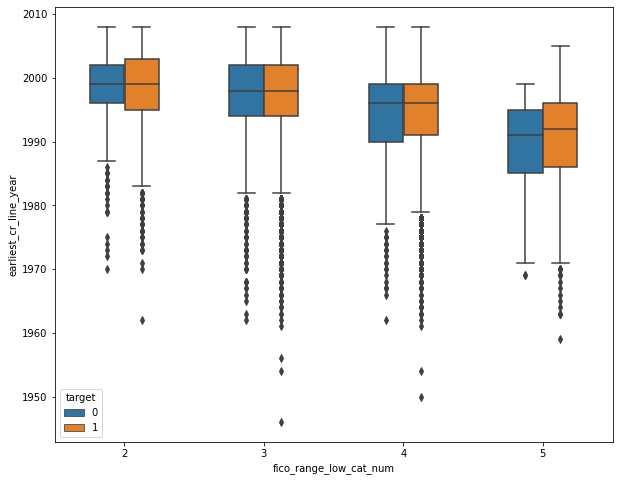

In [51]:
plt.figure(figsize=(10,8))
sns.boxplot(x="fico_range_low_cat_num", y="earliest_cr_line_year", hue="target", data=df, width=0.5)

Czy FICO score wpływa na zależność między targetem a earliest_cr_line:
- zależnośc między targetem a earliest_cr_line różni się między podgrupami fico score
- dla najniższej kategorii fico score "Fair" wśród niespłacających zakres zmiennej earliest_cr_line jest mniejszy, niż wśród pozostałych, natomiast mediana jest taka sama
- dla kategorii "Good"nie ma zauważalnej róznicy w rozkładzie earliest_cr_line między 0 i 1
- dla kategorii "very good" rozkład earliest_cr_line równiez jest bardzo podobny dla 0 i 1
- w kategorii "Exceptional" widoczna jest różnica między spłacającymi i niespłacającymi - wśród tych pierwszych rozkład przesunięty jest w stronę późniejszych lat.

<AxesSubplot:xlabel='fico_range_low_cat_num', ylabel='earliest_cr_line_year'>

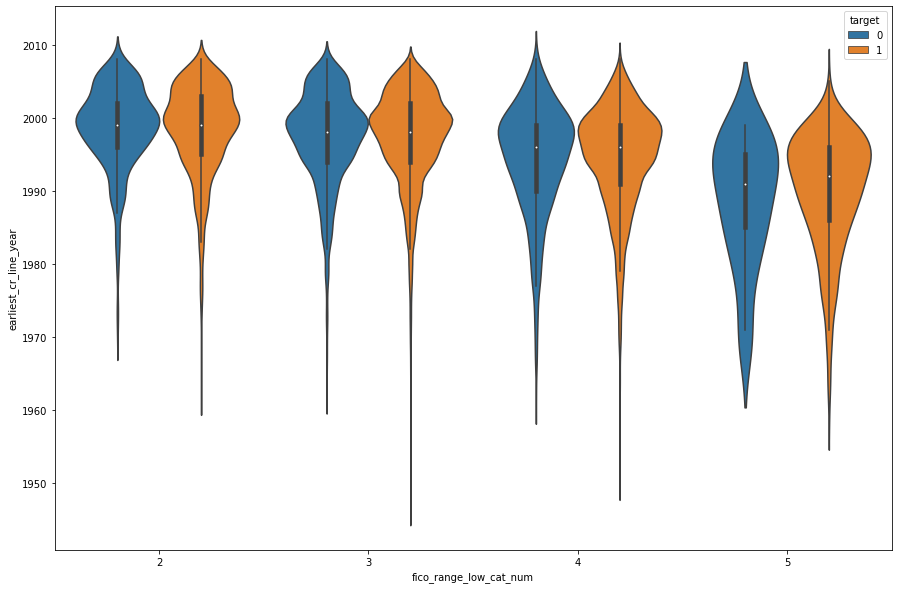

In [52]:
plt.figure(figsize=(15,10))
sns.violinplot(x="fico_range_low_cat_num", y="earliest_cr_line_year", hue="target", data=df)

Przedstawiając te same dane na wykresie violin możemy zauważyć jeszcze jedną prawidłowość - im wyższa kategoria FICO, tym bardziej rozciągnięty jest rozkład zmiennej earliest_cr_line_year, czyli tym większy zakres, bardziej różnorodna grupa.

Użyjmy jeszcze testu statystycznego, aby sprawdzić, czy średni wiek kredytowy jest różny w podgrupach spłacających i niespłacających.


In [53]:
processing.perform_ttest(df, 'target', 'earliest_cr_line_year')

T-test result: statistic = 4.469630119300937, p value =  7.857104050685182e-06


Różnica jest istotna statystycznie. 
Teraz sprawdzę jeszcze jak wyglądają te różnice w poszczególnych podgrupach Fico.

In [54]:
for group in df['fico_range_low_cat_num'].unique():
    stat, p = stats.ttest_ind(df.loc[(df['target']==0) & (df['fico_range_low_cat_num']==group)]['earliest_cr_line_year'], 
                            df.loc[(df['target']==1) & (df['fico_range_low_cat_num']==group)]['earliest_cr_line_year'])
    print(f'for group {group}: statistic: {stat}, p: {p}')

for group 3: statistic: -0.31094588400418144, p: 0.7558442527753161
for group 4: statistic: -0.7531733968684838, p: 0.4513632613418477
for group 2: statistic: 1.0166450916078278, p: 0.30940327763395775
for group 5: statistic: -0.9615328193028126, p: 0.336664071410241


T test pokazuje nam, że różnice wewnątrzgrupowe są nieistotne statystycznie. To by znaczyło, że większość zróżnicowania jest między grupami Fico. Jest to potwierdzenie tego, co wyczytałam z wykresów.

### issue_d

ISSUE_D_YEAR
count    39786.000000
mean      2010.329965
std          0.877178
min       2007.000000
25%       2010.000000
50%       2011.000000
75%       2011.000000
max       2011.000000
Name: issue_d_year, dtype: float64
Number of outliers in issue_d_year:  251
Średnia issue_d_year w podgrupach targetu:
target
0    2010.365785
1    2010.324012
Name: issue_d_year, dtype: float64
ISSUE_D_MONTH
count    39786.000000
mean         7.173026
std          3.396214
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: issue_d_month, dtype: float64
Number of outliers in issue_d_month:  0
Średnia issue_d_month w podgrupach targetu:
target
0    7.330511
1    7.146852
Name: issue_d_month, dtype: float64


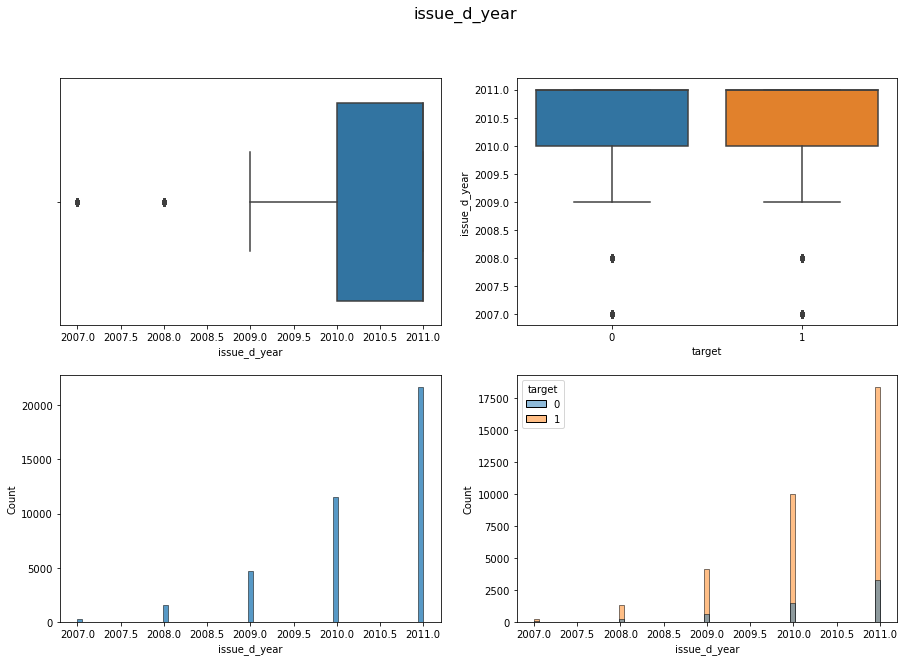

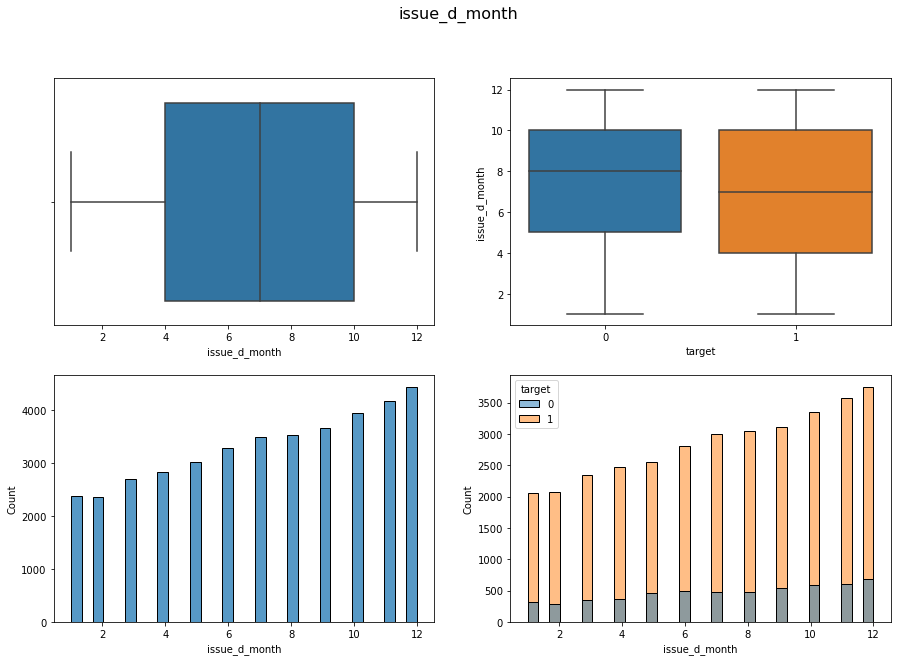

In [55]:
df['issue_d'] = pd.to_datetime(df['issue_d'], dayfirst=True)
df['issue_d_year'] = df['issue_d'].dt.year
df['issue_d_month'] = df['issue_d'].dt.month

column_list = ['issue_d_year', 'issue_d_month']
processing.display_analysis(df, column_list, 'target')

#### issue_d_year
- najwięcej obserwacji jest z lat 2010 i 2011 i właściwie to tyle, co możemy wyciągnąć z podstawowych rozkładów

#### issue_d_month
- tutaj już rozkład jest ciekawszy, ponieważ widać, że najwięcej kredytów zostało sfinansowane pod koniec roku - im dalszy miesiąc, tym większa liczebność.
- sprawdźmy, jakie są średnie zmiennej target w poszczeólnych miesiącach

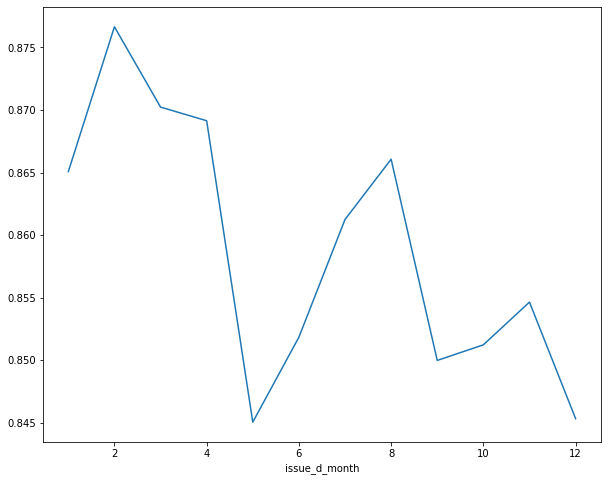

In [56]:
plt.figure(figsize=(10,8))
df.groupby('issue_d_month')['target'].mean().plot()
plt.show()

Można zauważyć bardzo ogólną tendencję spadkową odsetka spłacającyh wraz z kolejnymi miesiącami, z wyraźnym spadkiem również w maju. Biorąc pod uwagę możliwą zależność między tymi zmiennymi można wysunąć hipotezę, że najniższy odsetek spłacających był wśród tych, którzy swoją pozyczkę brali przed wakacjami lub przed świętami.

## Zmienne kategoryczne

### grade
- zmienna grade wskazuje na ocenę klienta z punktu widzenia ryzyka kredytowego. Przyjmuje 7 wartości od A do G, gdzie A to najlpszy klient (najmniejsze ryzyko) a G to najgorszy.
<!-- tutaj o grade'ach: https://www.lendingclub.com/foliofn/rateDetail.action -->

In [57]:
# zamieniam grade na numeryczną, aby móc zwizualizować dane na wykresie
df['grade_num'] = df['grade'].replace({"A": 1, 'B': 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7})
df['grade_num'] = pd.to_numeric(df['grade_num'])

GRADE_NUM
count    39786.000000
mean         2.579500
std          1.388213
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: grade_num, dtype: float64
Number of outliers in grade_num:  318
Średnia grade_num w podgrupach targetu:
target
0    3.232099
1    2.471040
Name: grade_num, dtype: float64


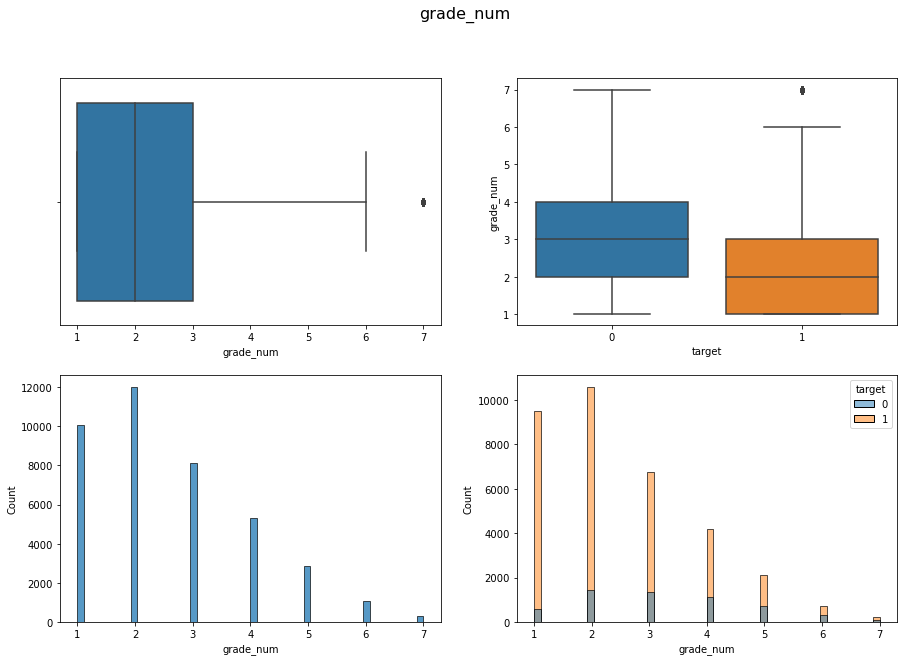

In [58]:
column_list = ['grade_num']
processing.display_analysis(df, column_list, 'target')

- outliers 318
- spłacający mają średnio niższą wartość zmiennej (2,47) niż niespłacający (3,23), co oznacza średnio wyższą klasę w klasyfikacji oceny kredytobiorcy wystawionej przez LC – różnica ta jest wyraźnie widoczna na boxplocie, pozostałe parametry również są analogicznie przesunięte (mediana, kwartyle)

### subgrade

Zmienna sub_grade jest rozszerzeniem zmiennej grade z nieco bardziej szczegółowym podziałem kategorii. Aby móc skorzystać z tej zmiennej potrzebowalibyśmy zamienić ją na wartości numeryczne, co jest uzasadnione ze względu na uszeregowanie kategorii zmiennej.

In [59]:
print(sorted(list(df['sub_grade'].unique())))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


Jednak sądzę, że zmienna grade zawiera wystarczająco informacji i nie muszę włączać zmiennej subgrade do predyktorów, więc nie będę jej rekodować.

### purpose

In [60]:
print(list(df['purpose'].unique()))

['credit_card', 'car', 'small_business', 'other', 'wedding', 'debt_consolidation', 'home_improvement', 'major_purchase', 'medical', 'moving', 'vacation', 'house', 'renewable_energy', 'educational']


Zmienna określająca cel, na jaki została wzięta pożyczka. Ze względu na liczbę wartości, tę zmiennej również nie będe rekodować.

### home_ownership

In [61]:
processing.print_distribution_in_percents(df, 'home_ownership')

MORTGAGE    44.50
NONE         0.01
OTHER        0.25
OWN          7.70
RENT        47.55
Name: home_ownership, dtype: float64


Zdecydowana większość klientów wynajmuje dom lub posiada kredyt hipoteczny na dom. 

In [62]:
df.groupby('home_ownership')['target'].mean()

home_ownership
MORTGAGE    0.867198
NONE        1.000000
OTHER       0.816327
OWN         0.854439
RENT        0.849086
Name: target, dtype: float64

Można zauważyć różnice w odsetku osób spłacających kredyt w poszczególnych grupach własności domu.Biorąc pod uwage tylko najczęstsze wartości najniższy odsetek jest wśród osób wynajmujących dom (85%), trochę wyższy wśród osób posiadających dom (85,5%) oraz najwyższy wśród osób posiadających hipotekę (87%). Są to jednakże różnice niewielkie.

###  W jaki sposób status kredytu hipotecznego na dom wiąże się z prawdopodobieństwem niewypłacalności?


Aby odpowiedzieć na to pytanie, stworzę sobie zmienną binarną, mówiącą o tym, czy klient ma kredyt hipoteczny, czy nie. Wykorzystam do tego zmienną home_ownership, która zawiera wśród wartości wartość "MORTGAGE", którą rozumiem własnie jako posiadanie kredytu hipotecznego na dom.
Przy okazji stworzę też zmienne binarne odpowiadające pozostałym wartościom zmiennej home_ownership.

In [63]:
df = pd.get_dummies(df, columns=['home_ownership'], prefix='home')

In [64]:
df = df.drop(columns='home_NONE')

In [65]:
df.groupby('target')['home_MORTGAGE'].mean()

target
0    0.414638
1    0.449994
Name: home_MORTGAGE, dtype: float64

Wśród spłacających kredyt jest ok 45% osób, które mają kredyt hipoteczny na dom, natomiast wśród niespłacających jest to trochę mniej, bo 41%.

In [66]:
df.groupby('home_MORTGAGE')['target'].mean()

home_MORTGAGE
0    0.849703
1    0.867198
Name: target, dtype: float64

Wśród tych, którzy mają kredyt hipoteczny na dom, ok 87% spłaciło kredyt. Wśród tych, którzy tego kredytu nie mają, ok 85% spłaciło kredyt.
Różnica jest niewielka, podobnie jak w analizie wyżej, jednak obie analizy prowadzą do tej samej hipotezy: posiadanie kredytu hipotecznego na dom nieznacznie zwiększa prawdopodobieństwo spłacenia kredytu. Sprawdźmy, czy potwierdza to test statystyczny.

In [67]:
processing.perform_ttest(df, 'home_MORTGAGE', 'target')

T-test result: statistic = -4.962105569208717, p value =  7.002046321967414e-07


Różnica jest istotna statystycznie, czyli test potwierdza, że osoby posiadające kredyt hipoteczny mają inne prawopodobieństwo spłacenia kredytu niz osoby nieposiadając kredytu hipotecznego.

<AxesSubplot:>

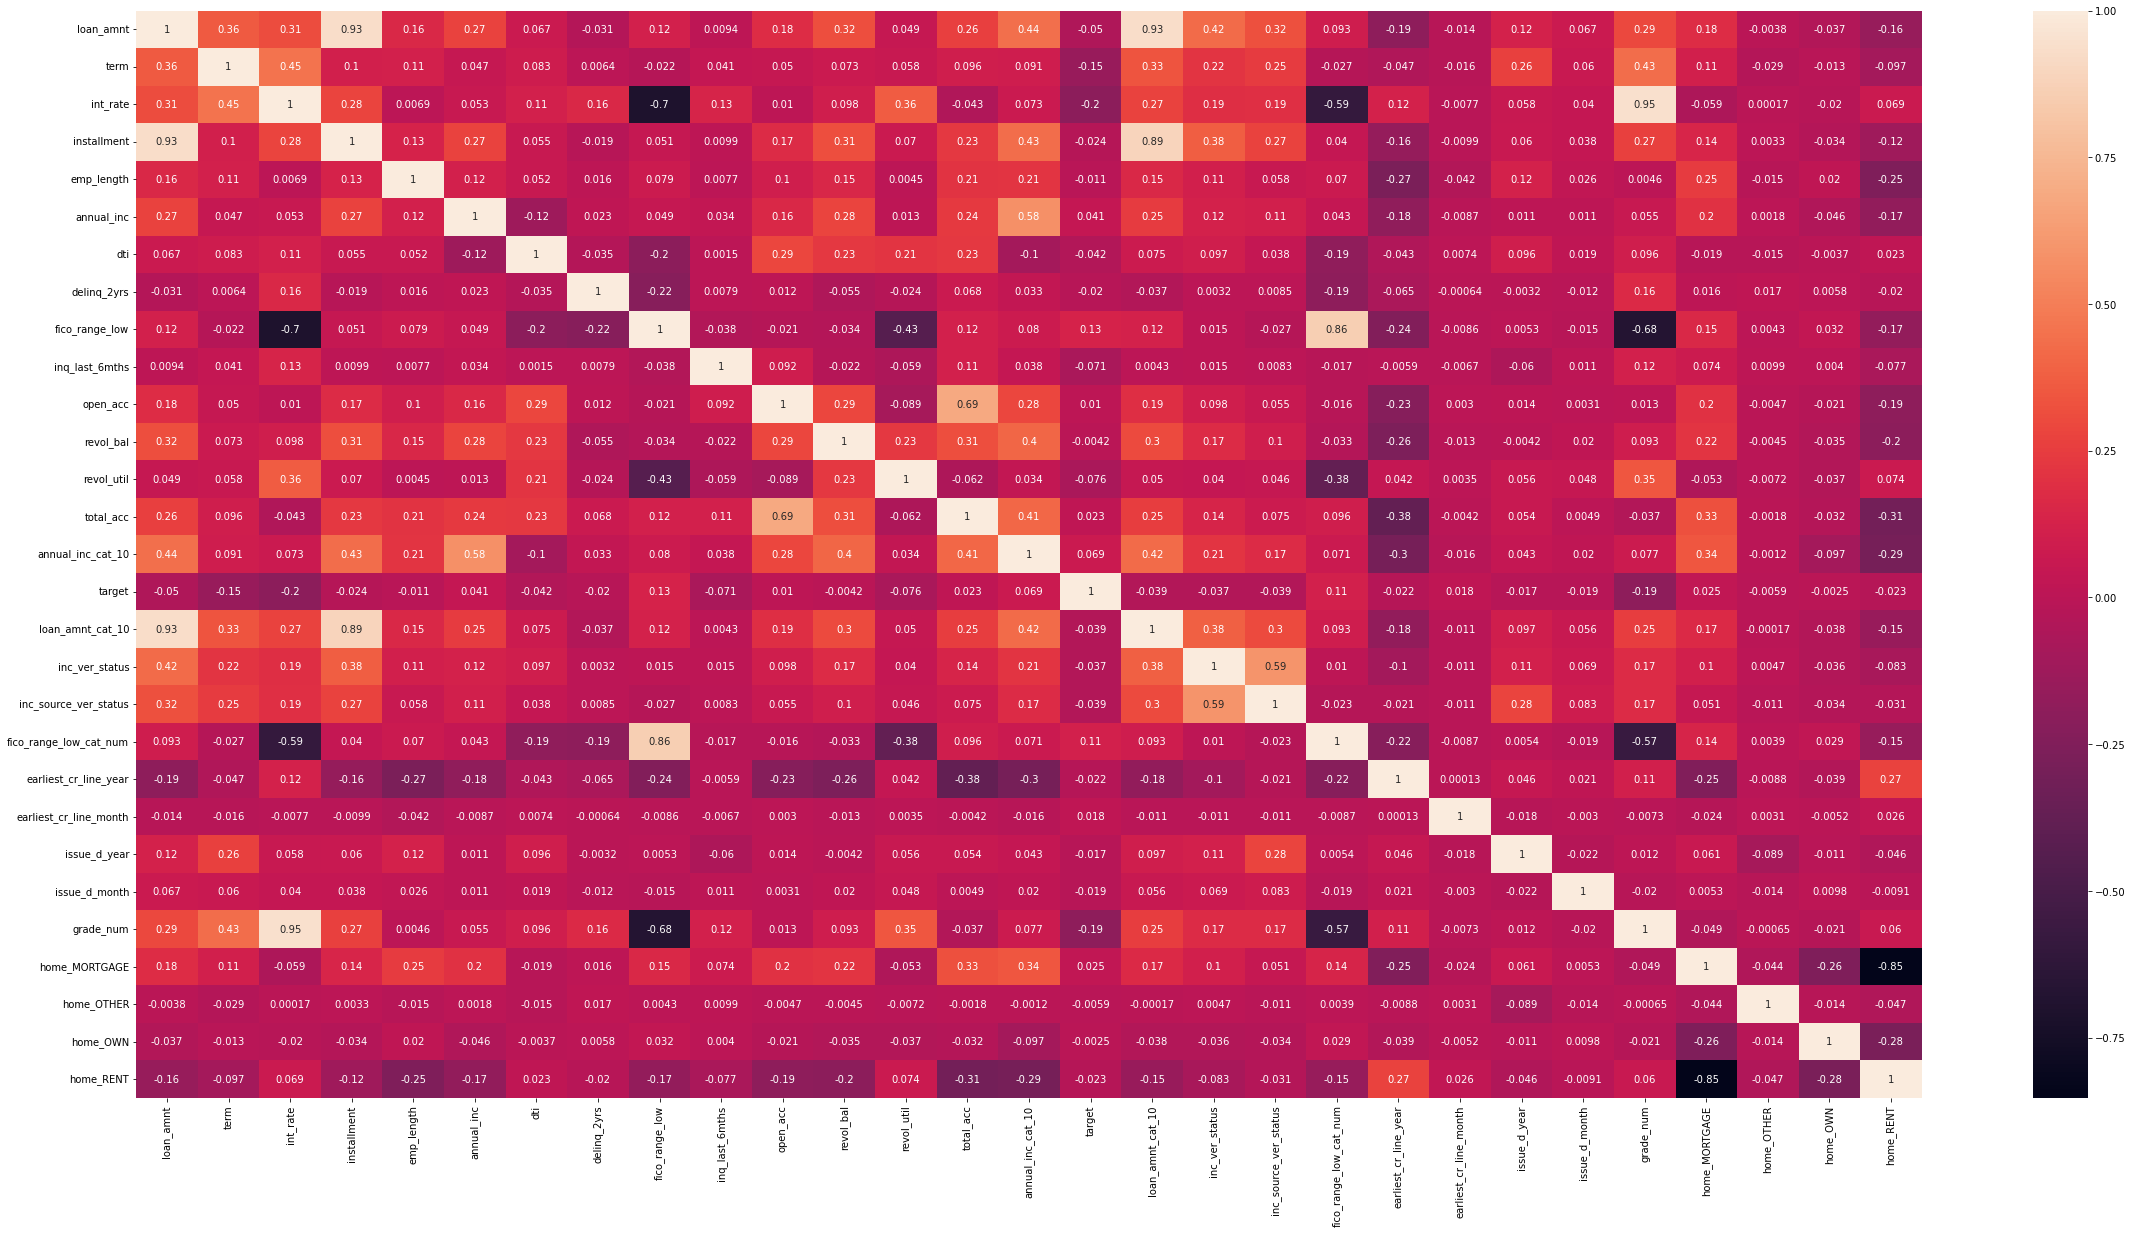

In [68]:
# buduję znów tablicę korelacji
plt.figure(figsize = (40,20))       
sns.heatmap(df.corr(),annot = True)

Na tablicy korelacji wciąż widać zmienne o wysokiej zależności liniowej. Jednak te zmienne już zostawiam, będę do modelu wybierać różne warianty predyktorów.

In [69]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'annual_inc', 'verification_status', 'issue_d', 'purpose',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low',
       'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc',
       'annual_inc_cat_10', 'fico_range_low_cat', 'target', 'loan_amnt_cat_10',
       'inc_ver_status', 'inc_source_ver_status', 'fico_range_low_cat_num',
       'earliest_cr_line_year', 'earliest_cr_line_month', 'issue_d_year',
       'issue_d_month', 'grade_num', 'home_MORTGAGE', 'home_OTHER', 'home_OWN',
       'home_RENT'],
      dtype='object')

Do tej pory w ramach analizy ekspoloracyjnej stworzyłam 15 nowych zmiennych, które przekształciły zmienne istniejące. W następnej części postaram się stworzyć dodatkowe zmienne, które mogą być pomocne dla budowanych modeli klasyfikacyjnych.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   loan_amnt               39786 non-null  float64       
 1   term                    39786 non-null  int64         
 2   int_rate                39786 non-null  int64         
 3   installment             39786 non-null  float64       
 4   grade                   39786 non-null  object        
 5   sub_grade               39786 non-null  object        
 6   emp_length              39786 non-null  float64       
 7   annual_inc              39786 non-null  float64       
 8   verification_status     39786 non-null  object        
 9   issue_d                 39786 non-null  datetime64[ns]
 10  purpose                 39786 non-null  object        
 11  dti                     39786 non-null  float64       
 12  delinq_2yrs             39786 non-null  float6

In [71]:
# usuwam zmienne, które zostały zrekodowane na numeryczne, lub takie, które służyły mi tylko
# do uzupełnienia missing values
df = df.drop(columns = ['grade', 'sub_grade', 'verification_status', 'purpose', 
                        'fico_range_low_cat', 'earliest_cr_line', 'issue_d'])

In [72]:
df.shape

(39786, 29)

In [73]:
df.to_csv('Loan_data_after_eda.csv', index=False)